In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) 

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [2]:
df = pd.read_csv('app/data/polling/president_primary_polls.csv', low_memory=False)

df

question_id  poll_id  cycle state  pollster_id  \
0           121552    65756   2020   NaN          568   
1           121552    65756   2020   NaN          568   
2           121390    65691   2020   NaN          568   
3           121390    65691   2020   NaN          568   
4           121424    65687   2020   NaN         1361   
...            ...      ...    ...   ...          ...   
18636        92392    57184   2020   NaN         1416   
18637        92392    57184   2020   NaN         1416   
18638        92392    57184   2020   NaN         1416   
18639        92392    57184   2020   NaN         1416   
18640        92392    57184   2020   NaN         1416   

                          pollster sponsor_ids   sponsors display_name  \
0                           YouGov         352  Economist       YouGov   
1                           YouGov         352  Economist       YouGov   
2                           YouGov         352  Economist       YouGov   
3                           YouGov         352  Economist       YouGov   
4                             SSRS         143        CNN     CNN/SSRS   
...                            ...         ...        ...          ...   
18636  Harris Insights & Analytics         960    Hill.TV      HarrisX   
18637  Harris Insights & Analytics         960    Hill.TV      HarrisX   
18638  Harris Insights & Analytics         960    Hill.TV      HarrisX   
18639  Harris Insights & Analytics         960    Hill.TV      HarrisX   
18640  Harris Insights & Analytics         960    Hill.TV      HarrisX   

       pollster_rating_id         pollster_rating_name fte_grade  sample_size  \
0                   391.0                       YouGov        B-          585   
1                   391.0                       YouGov        B-          585   
2                   391.0                       YouGov        B-          586   
3                   391.0                       YouGov        B-          586   
4                   297.0                         SSRS       A/B          462   
...                   ...                          ...       ...          ...   
18636               133.0  Harris Insights & Analytics        C+          370   
18637               133.0  Harris Insights & Analytics        C+          370   
18638               133.0  Harris Insights & Analytics        C+          370   
18639               133.0  Harris Insights & Analytics        C+          370   
18640               133.0  Harris Insights & Analytics        C+          370   

      population population_full methodology     office_type start_date  \
0             lv            lv-d      Online  U.S. President    4/12/20   
1             lv            lv-d      Online  U.S. President    4/12/20   
2             lv            lv-d      Online  U.S. President     4/5/20   
3             lv            lv-d      Online  U.S. President     4/5/20   
4             rv            rv-d  Live Phone  U.S. President     4/3/20   
...          ...             ...         ...             ...        ...   
18636         rv            rv-d      Online  U.S. President    11/5/18   
18637         rv            rv-d      Online  U.S. President    11/5/18   
18638         rv            rv-d      Online  U.S. President    11/5/18   
18639         rv            rv-d      Online  U.S. President    11/5/18   
18640         rv            rv-d      Online  U.S. President    11/5/18   

      end_date sponsor_candidate  internal partisan  tracking  \
0      4/14/20               NaN     False      NaN     False   
1      4/14/20               NaN     False      NaN     False   
2       4/7/20               NaN     False      NaN     False   
3       4/7/20               NaN     False      NaN     False   
4       4/6/20               NaN     False      NaN     False   
...        ...               ...       ...      ...       ...   
18636  11/6/18               NaN     False      NaN     False   
18637  11/6/18               NaN     Fa

In [35]:
candidates = {'John Delaney', 'Kamala Harris', 'Amy Klobuchar', 'Andrew Yang', 'Bernie Sanders', 'Elizabeth Warren', 
     'Joe Biden', 'Pete Buttigieg', 'Tom Steyer', 'Mike Bloomberg', 'Bill de Blasio', 'Cory Booker', 'Jay Inslee', 
     'Julián Castro', 'Kirsten Gillibrand', 'Michael Bennet', 'Tulsi Gabbard', 'Eric Swalwell', 'John Hickenlooper', 
     'Marianne Williamson', 'Beto O\'Rourke', 'Steve Bullock', 'Tim Ryan', 'Pete Buttigieig'}

candidates_map = {candidate.split(' ', 1)[1]: candidate for candidate in candidates}
df_filtered = df[df.answer.isin(candidates_map.keys())].replace(candidates_map)

df_filtered = df_filtered[df_filtered.state.isnull()]
df_filtered = df_filtered[~(df_filtered.fte_grade.str.contains('C') | df_filtered.fte_grade.str.contains('D'))]

df_filtered = df_filtered[['created_at', 'answer', 'pct']]

df_filtered.created_at = pd.to_datetime(df_filtered.created_at)
df_filtered = df_filtered.sort_values(by=['created_at'])
df_filtered.reset_index(inplace=True)

df_filtered

index          created_at            answer   pct
0     18552 2018-12-27 03:58:00         Joe Biden  25.5
1     18550 2018-12-27 03:58:00     Kamala Harris   8.5
2     18549 2018-12-27 03:58:00    Bernie Sanders  22.0
3     18548 2018-12-27 03:58:00  Elizabeth Warren   6.9
4     18551 2018-12-27 03:58:00     Beto O'Rourke  15.1
...     ...                 ...               ...   ...
4008     33 2020-04-11 19:09:00         Joe Biden  38.0
4009     34 2020-04-11 19:09:00    Bernie Sanders  30.0
4010     36 2020-04-11 19:09:00    Mike Bloomberg   8.0
4011      1 2020-04-15 09:11:00    Bernie Sanders  31.0
4012      0 2020-04-15 09:11:00         Joe Biden  49.0

[4013 rows x 4 columns]

In [4]:
def smooth(temp):    
    # remove outliers
    temp['avg_pct'] = temp.pct.rolling(20, min_periods=1, center=True).mean()
    temp['stand_dev'] = temp.pct.rolling(20, min_periods=1, center=True).std()
    temp = temp[(temp.pct > temp.avg_pct - 2*temp.stand_dev) & (temp.pct < temp.avg_pct + 2*temp.stand_dev)]

    # smoothing
    temp.avg_pct = temp.pct.rolling(20, min_periods=1, center=True).mean()
    temp.avg_pct = temp.avg_pct.rolling(20, min_periods=1, center=True).mean()
    
    return temp

df_filtered2 = df_filtered.groupby(by='answer').apply(smooth).reset_index(drop=True)

Biden


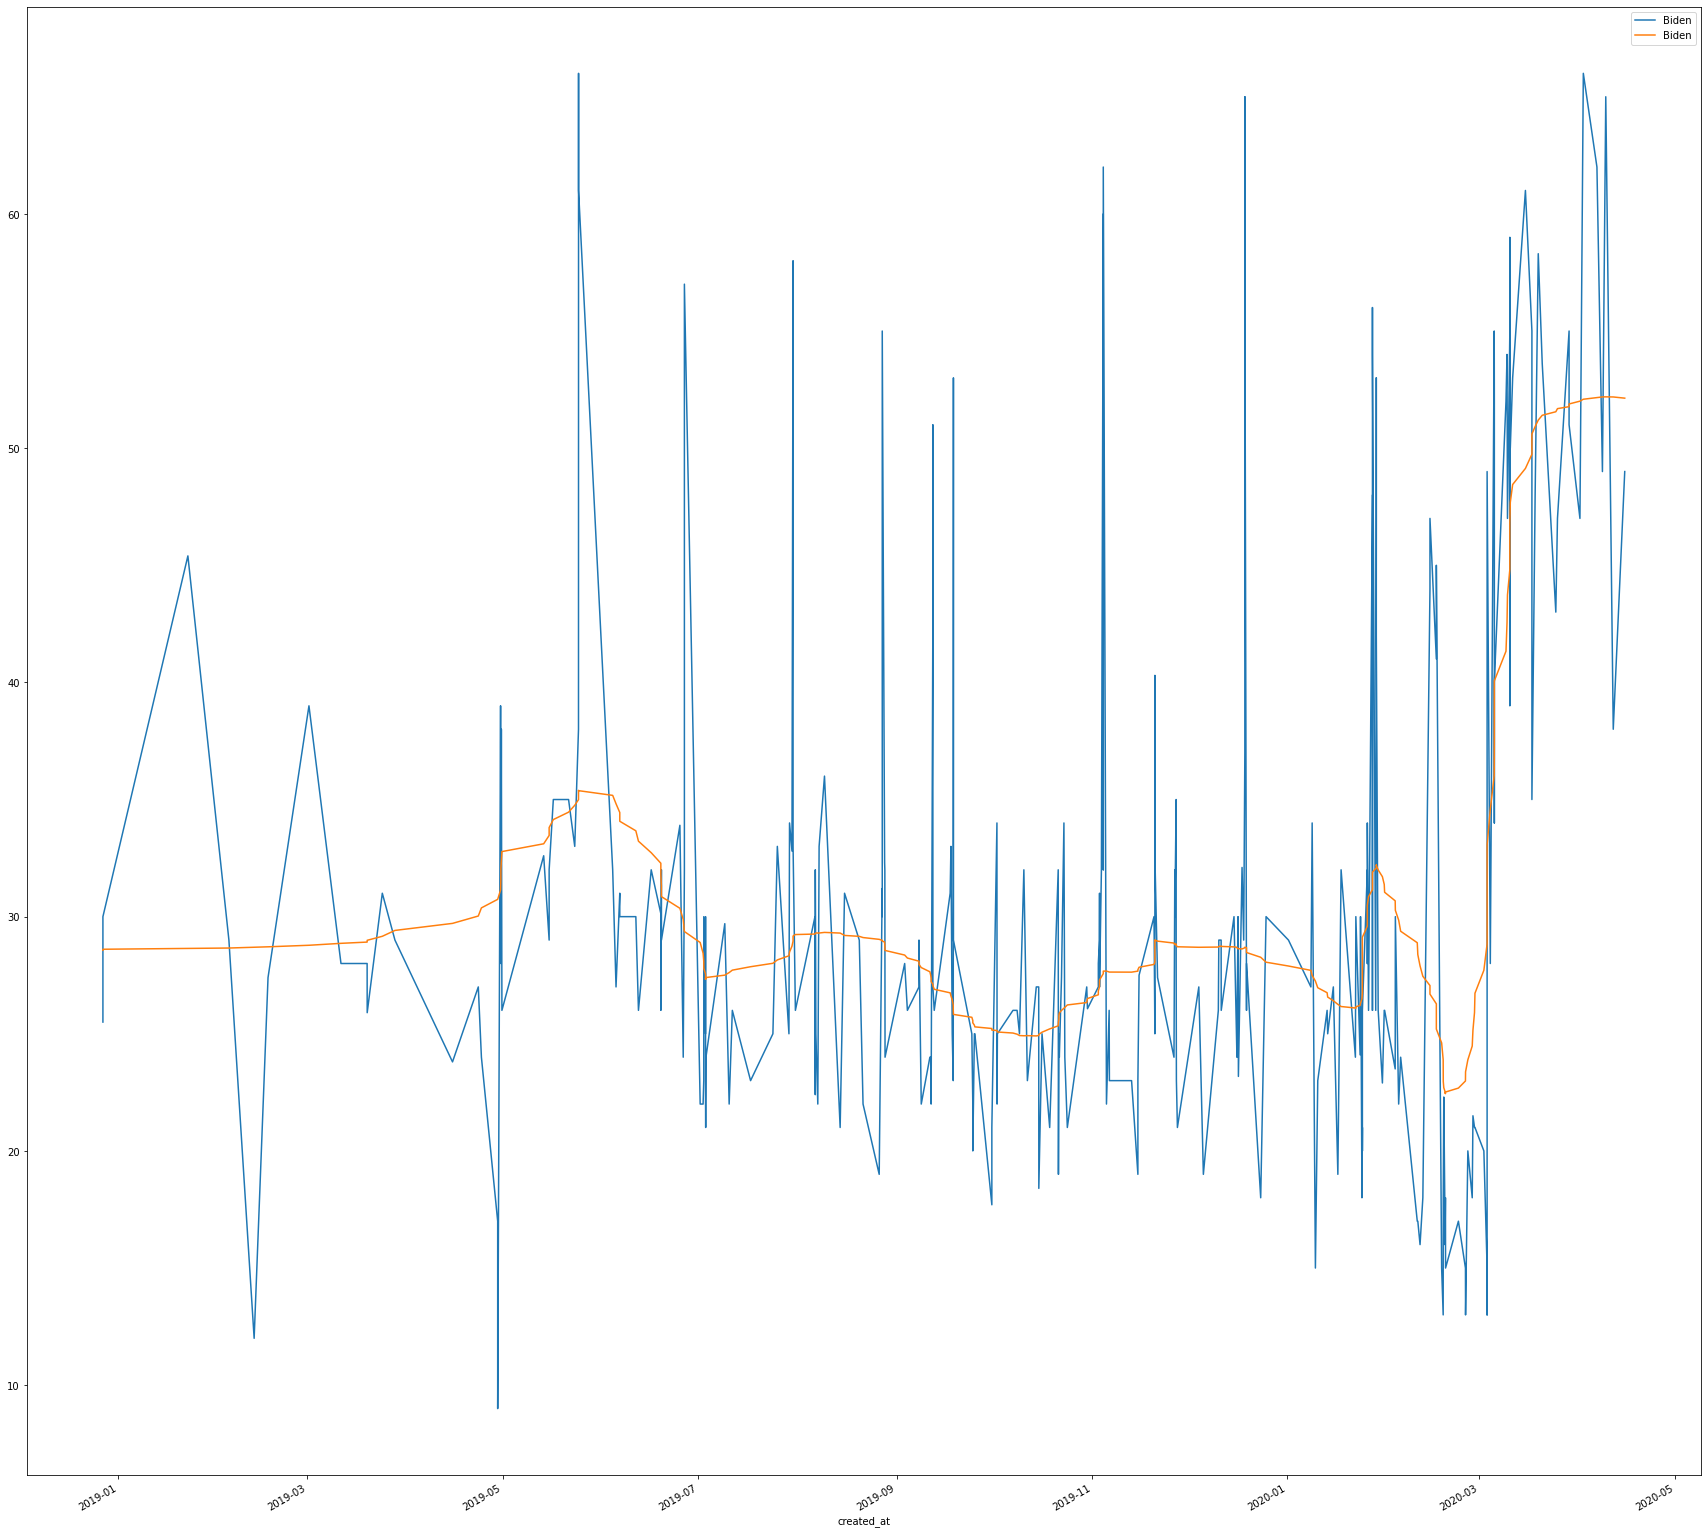

Harris


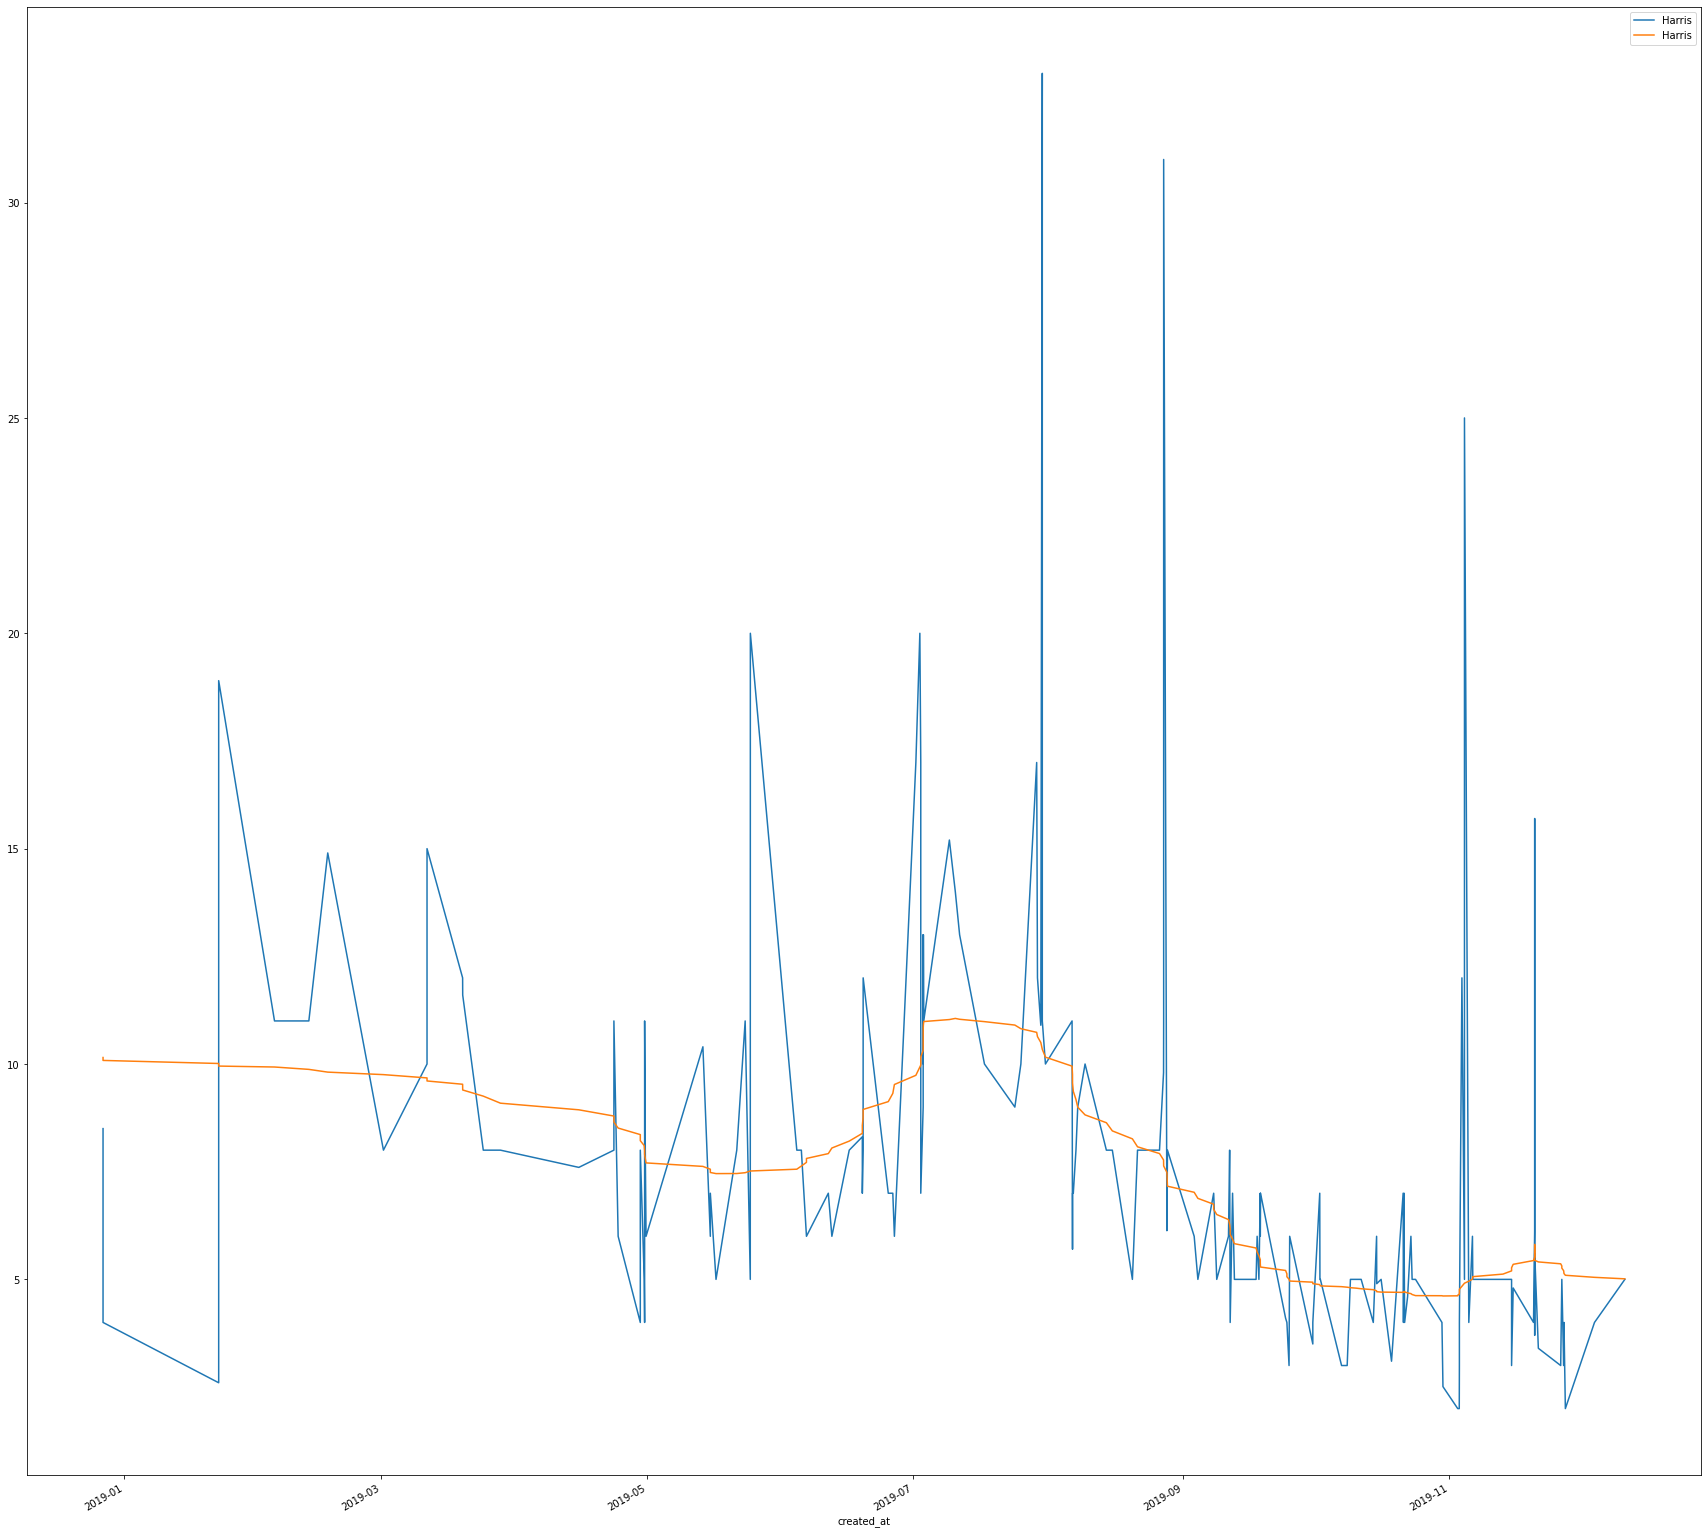

Sanders


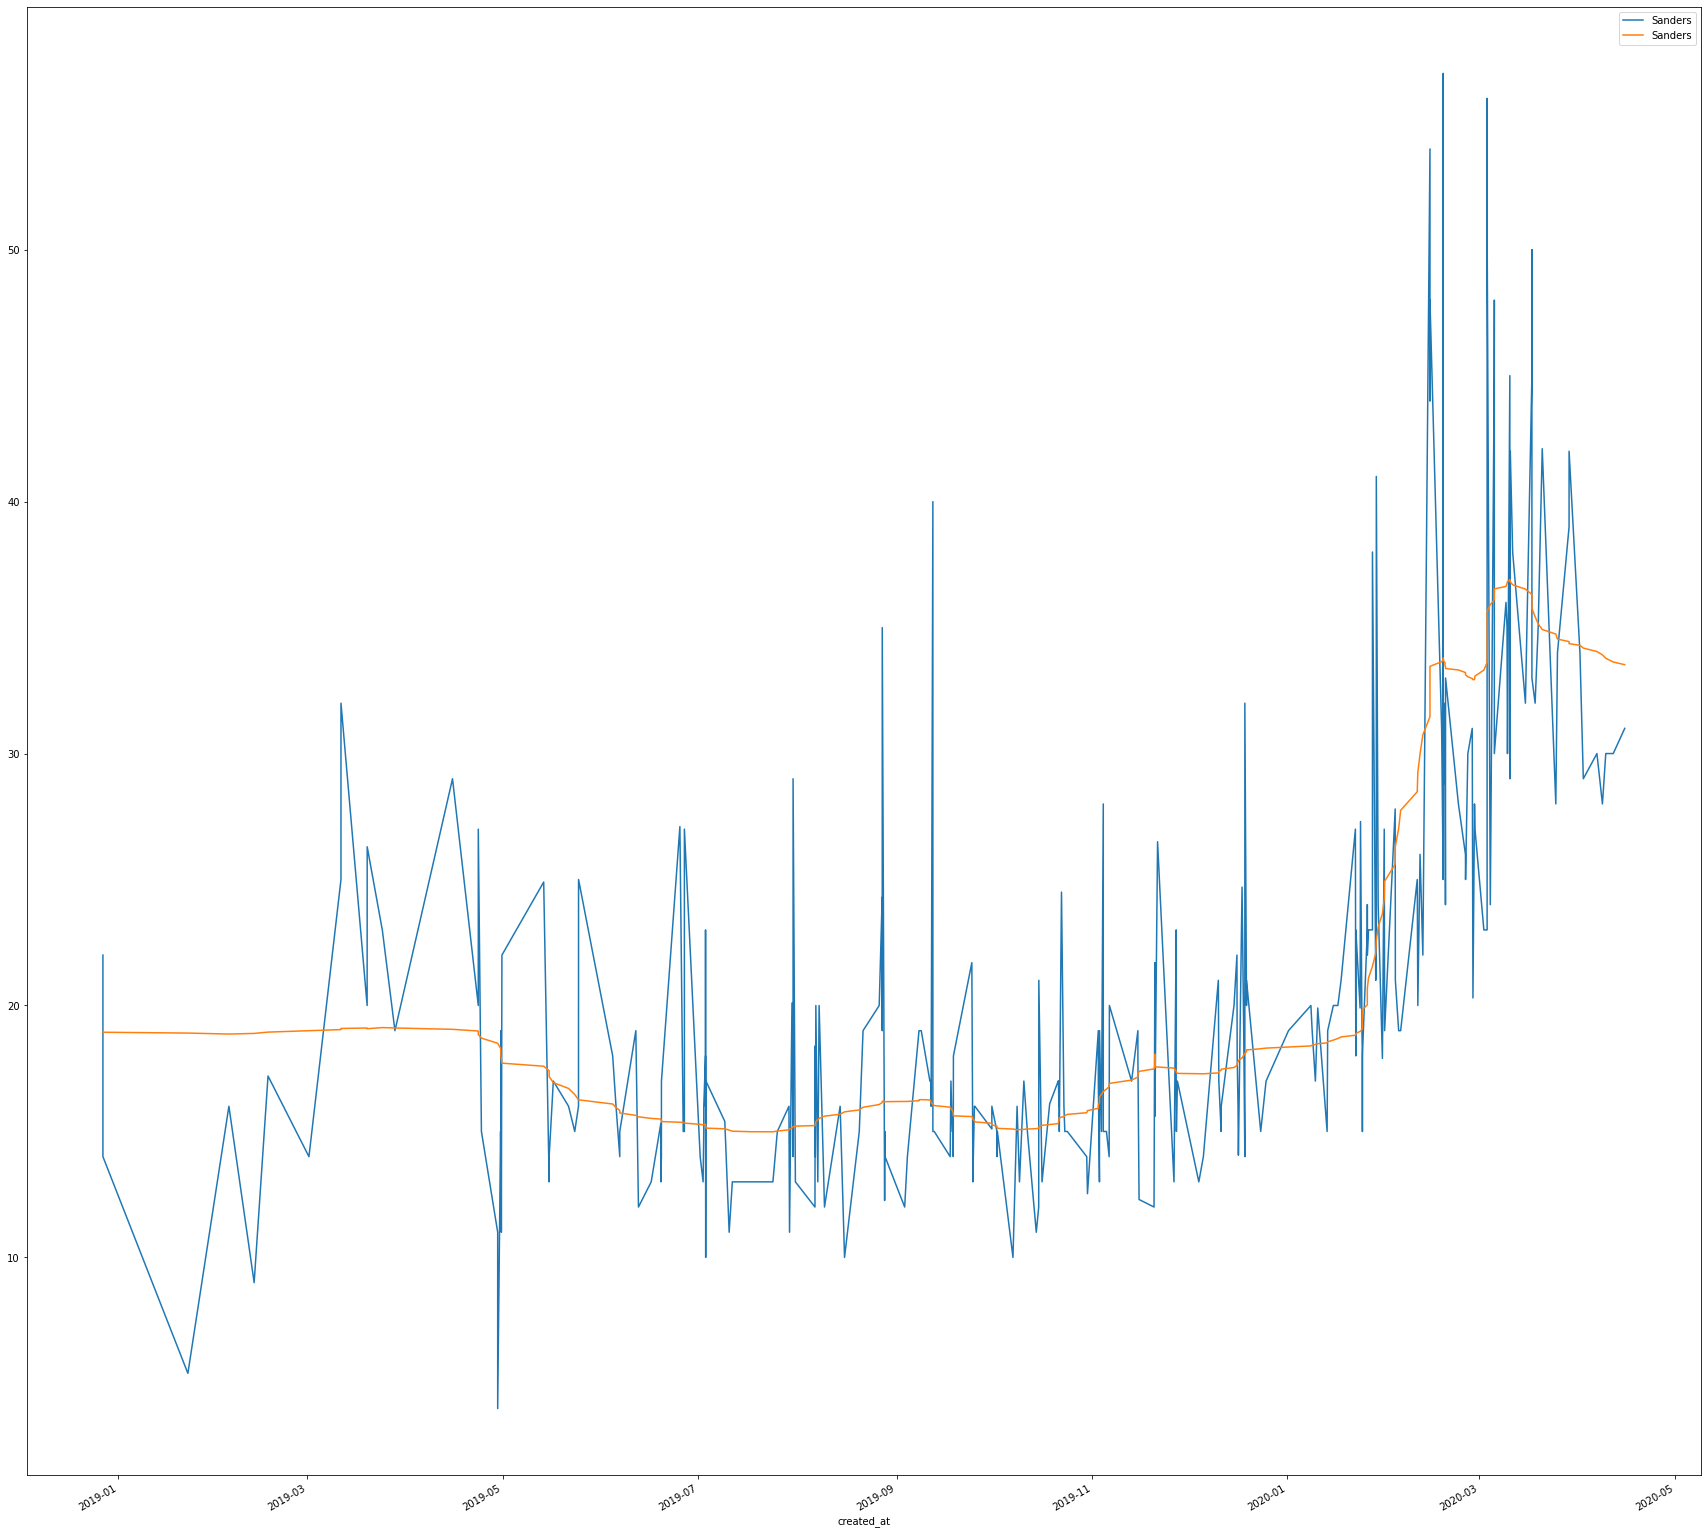

Warren


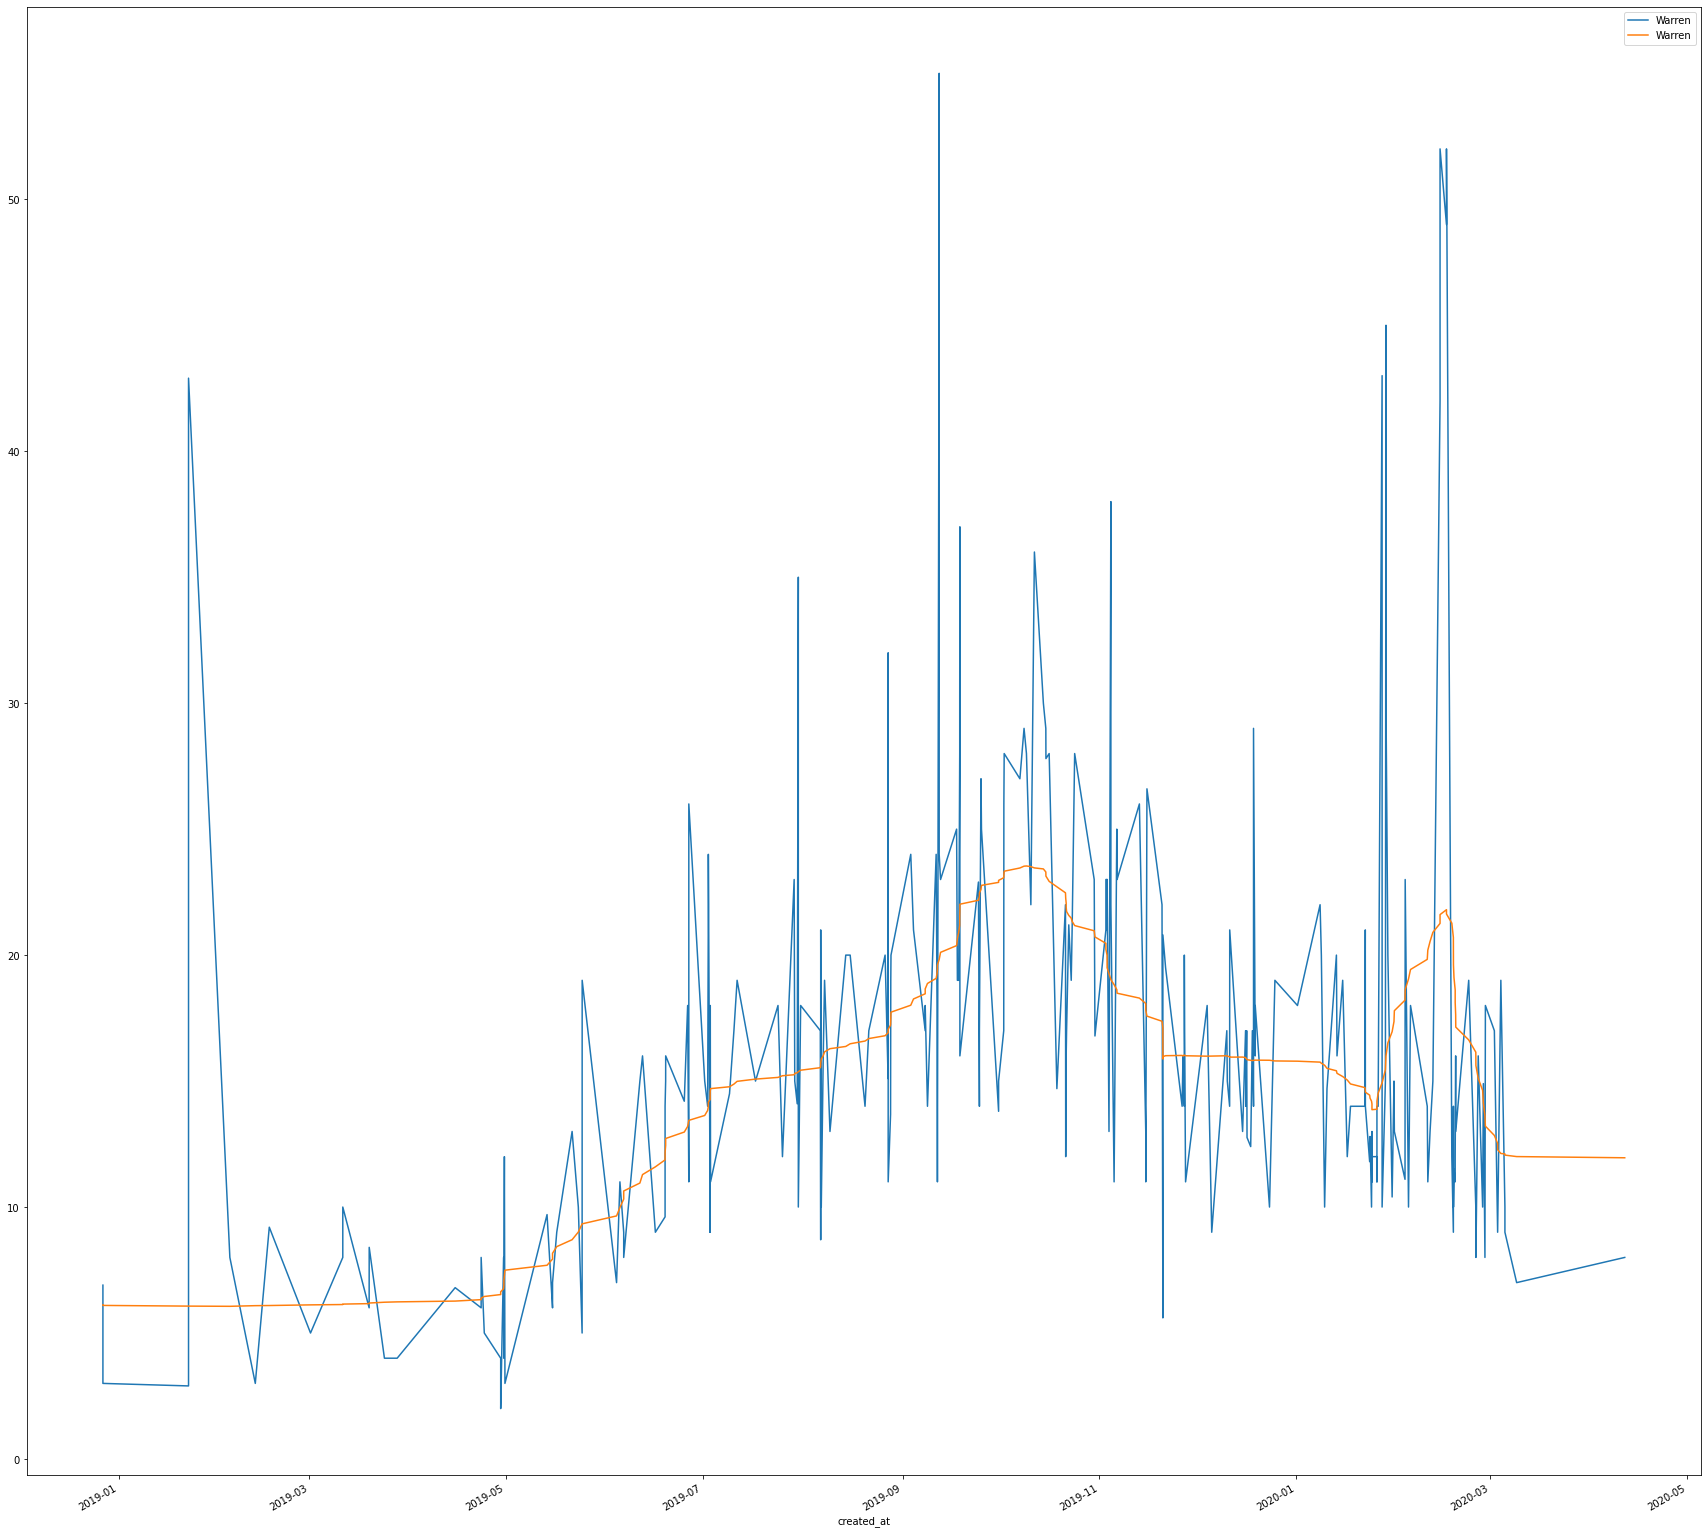

O'Rourke


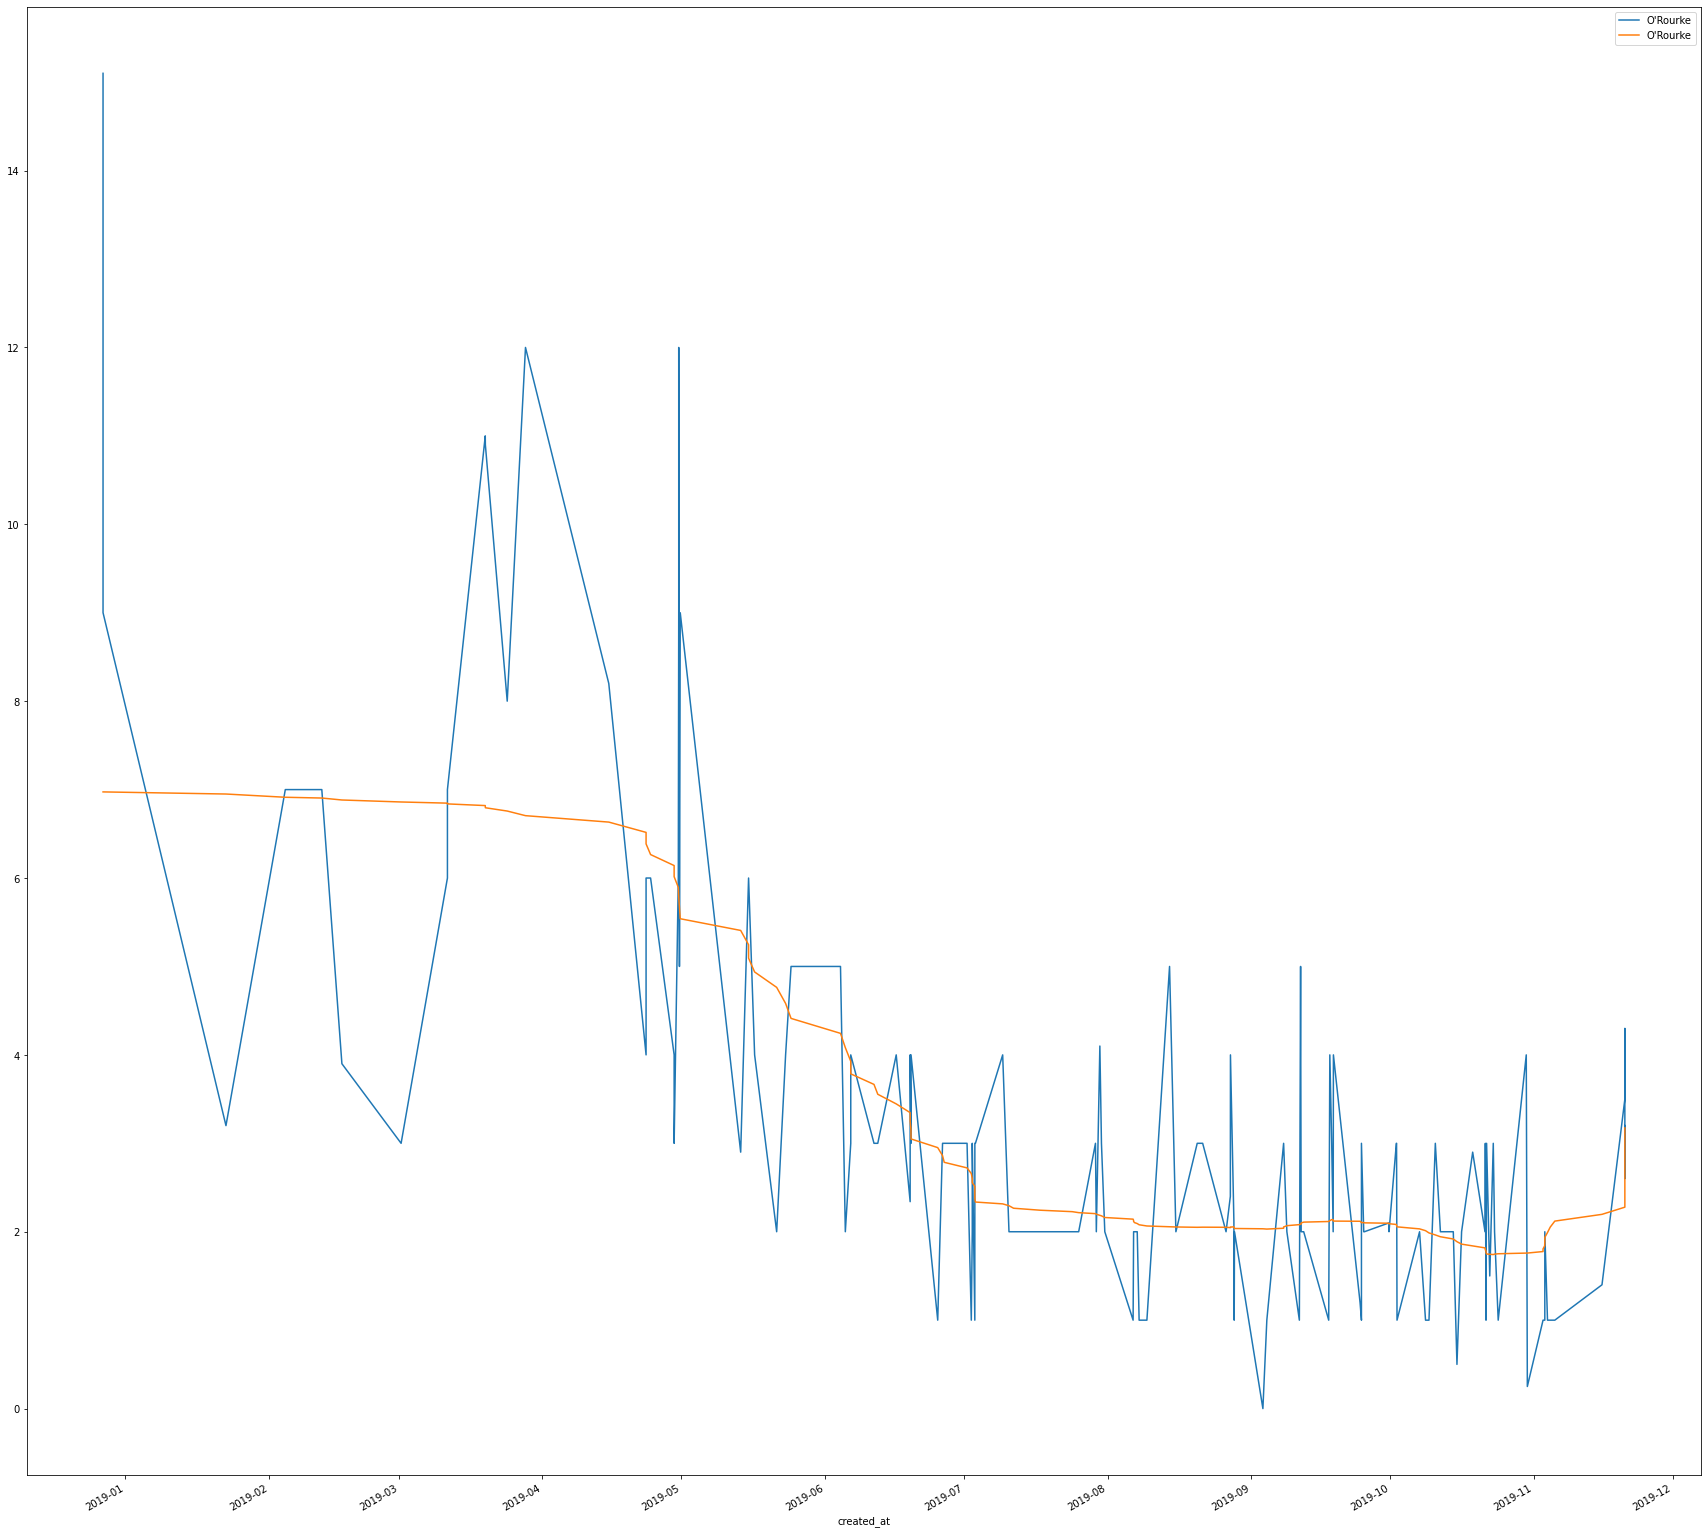

Hickenlooper


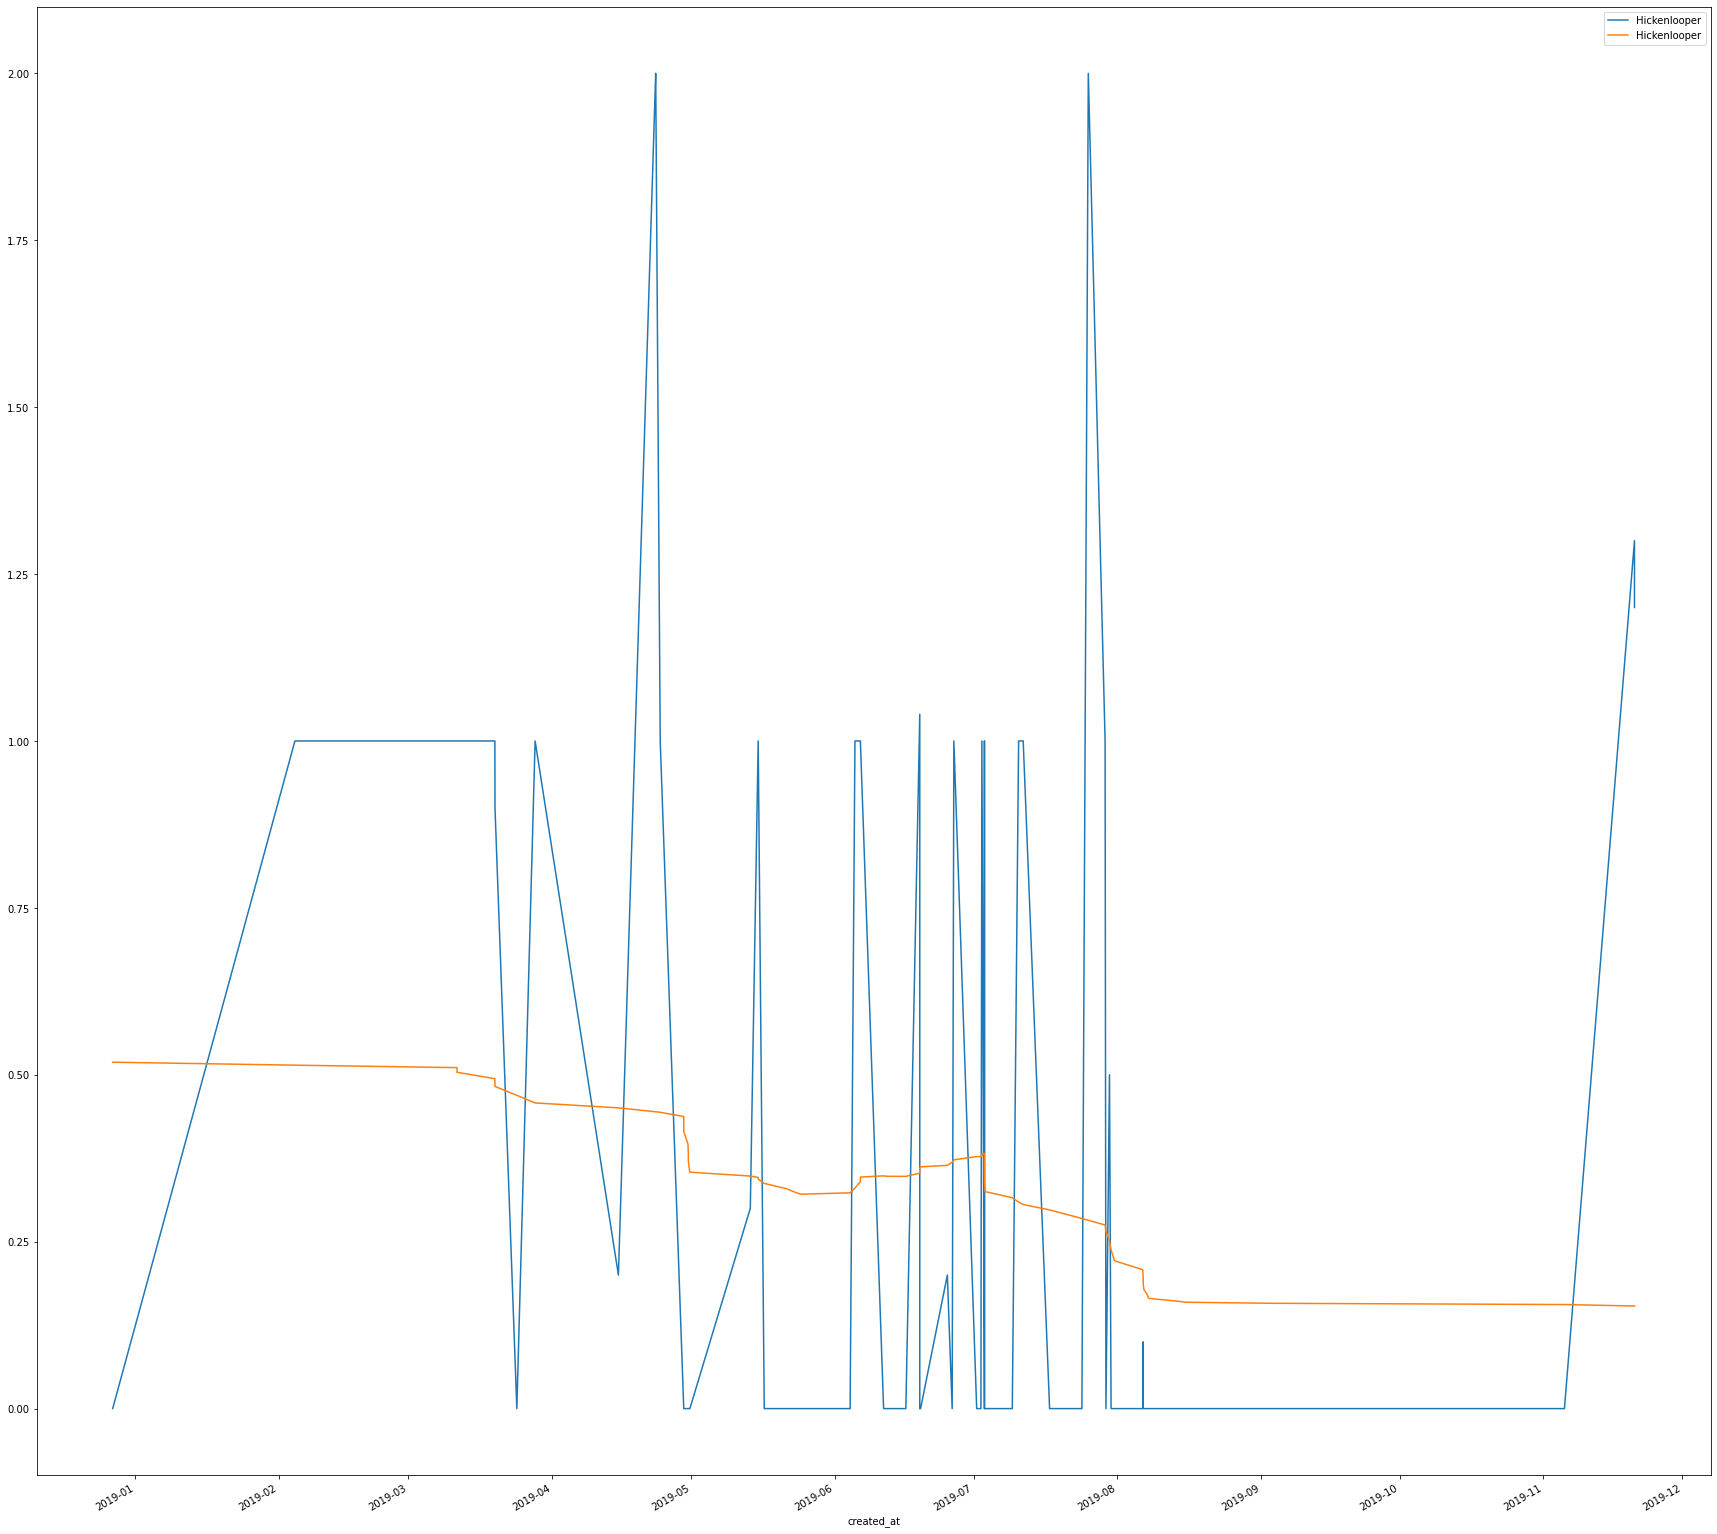

Castro


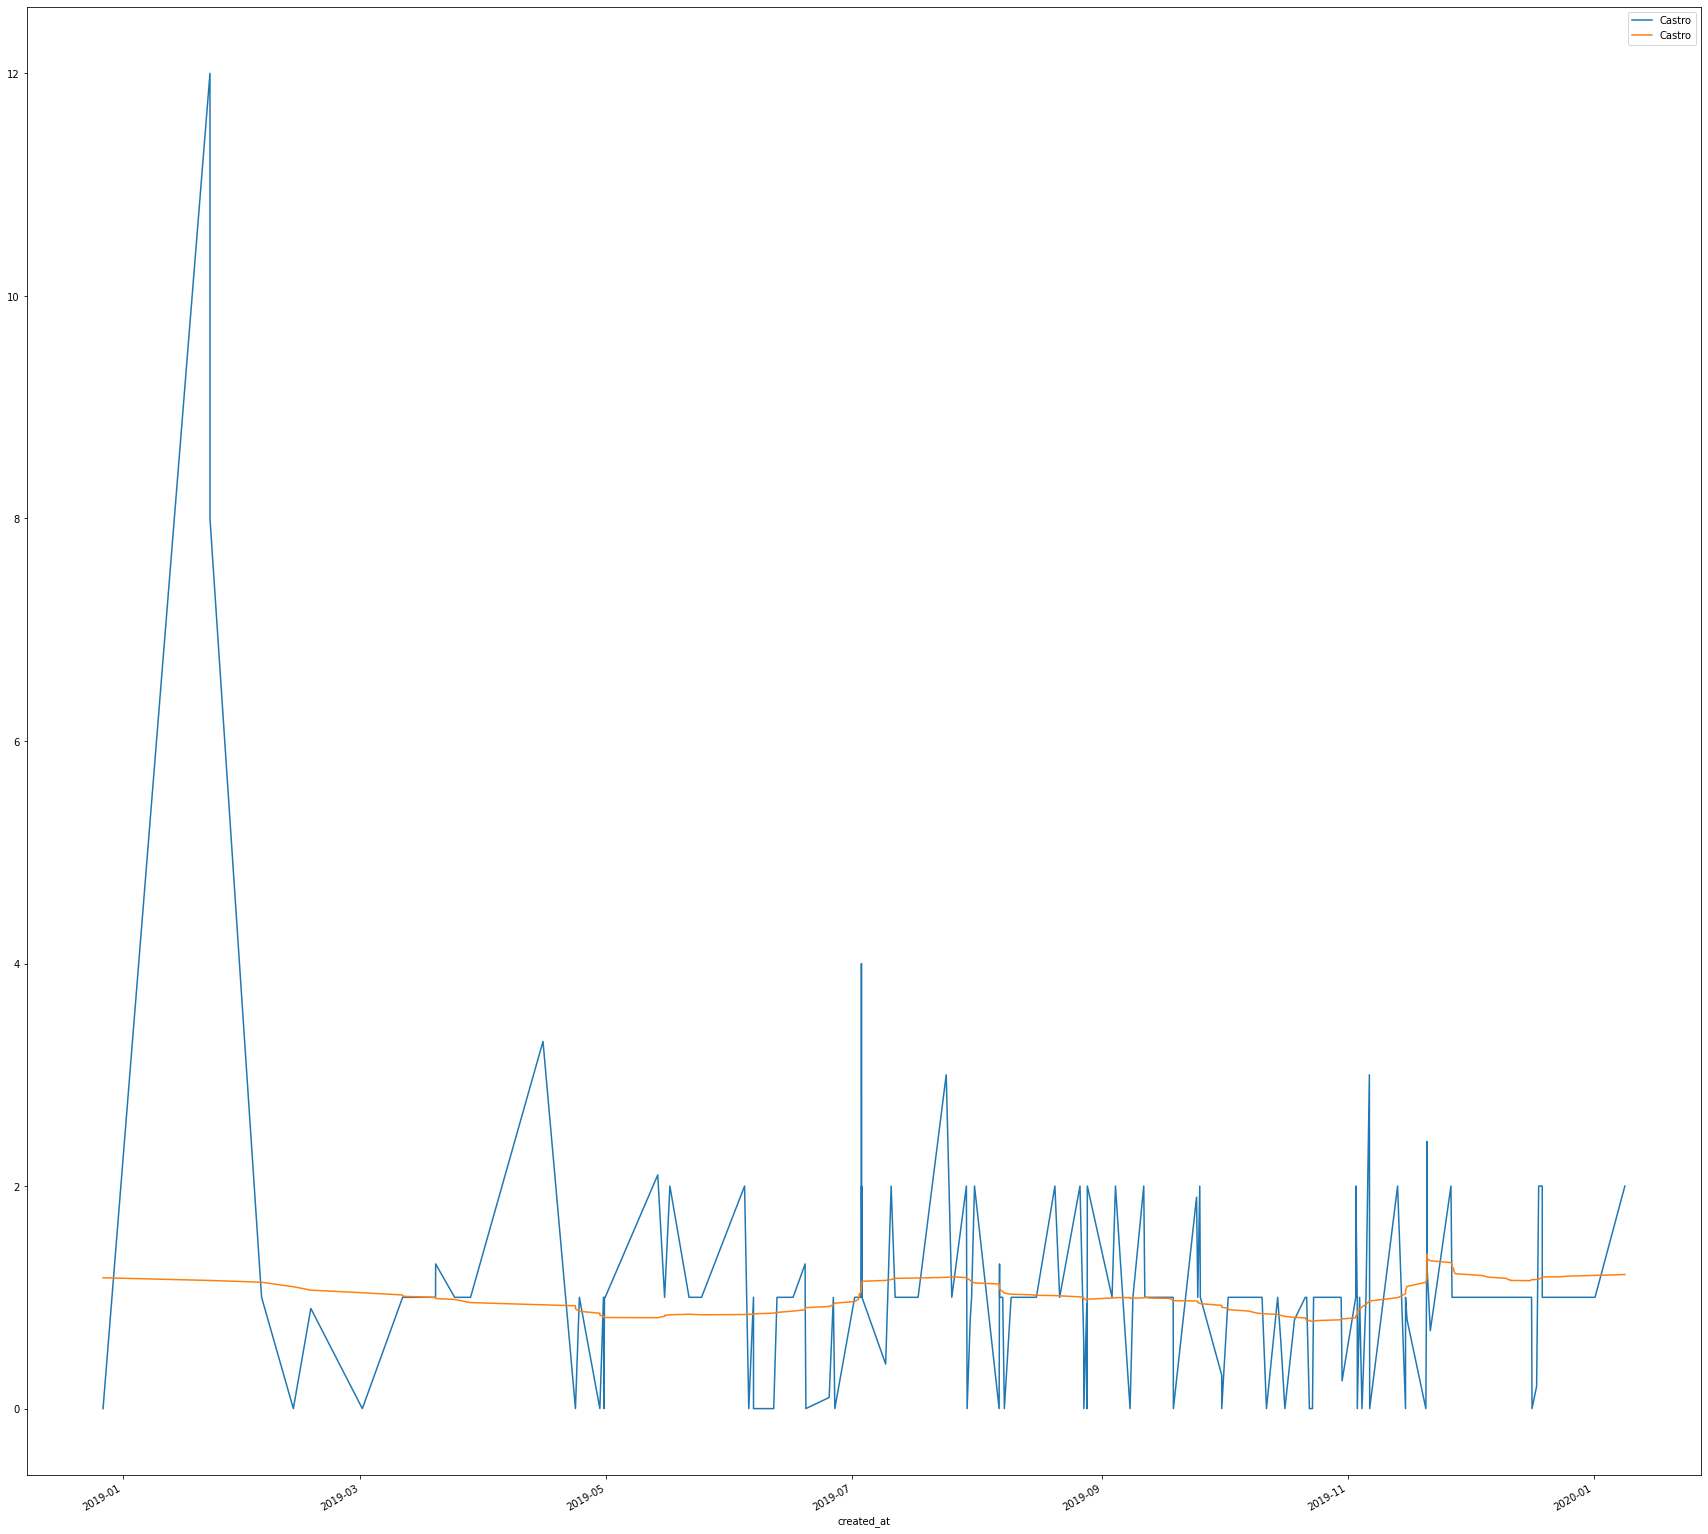

Inslee


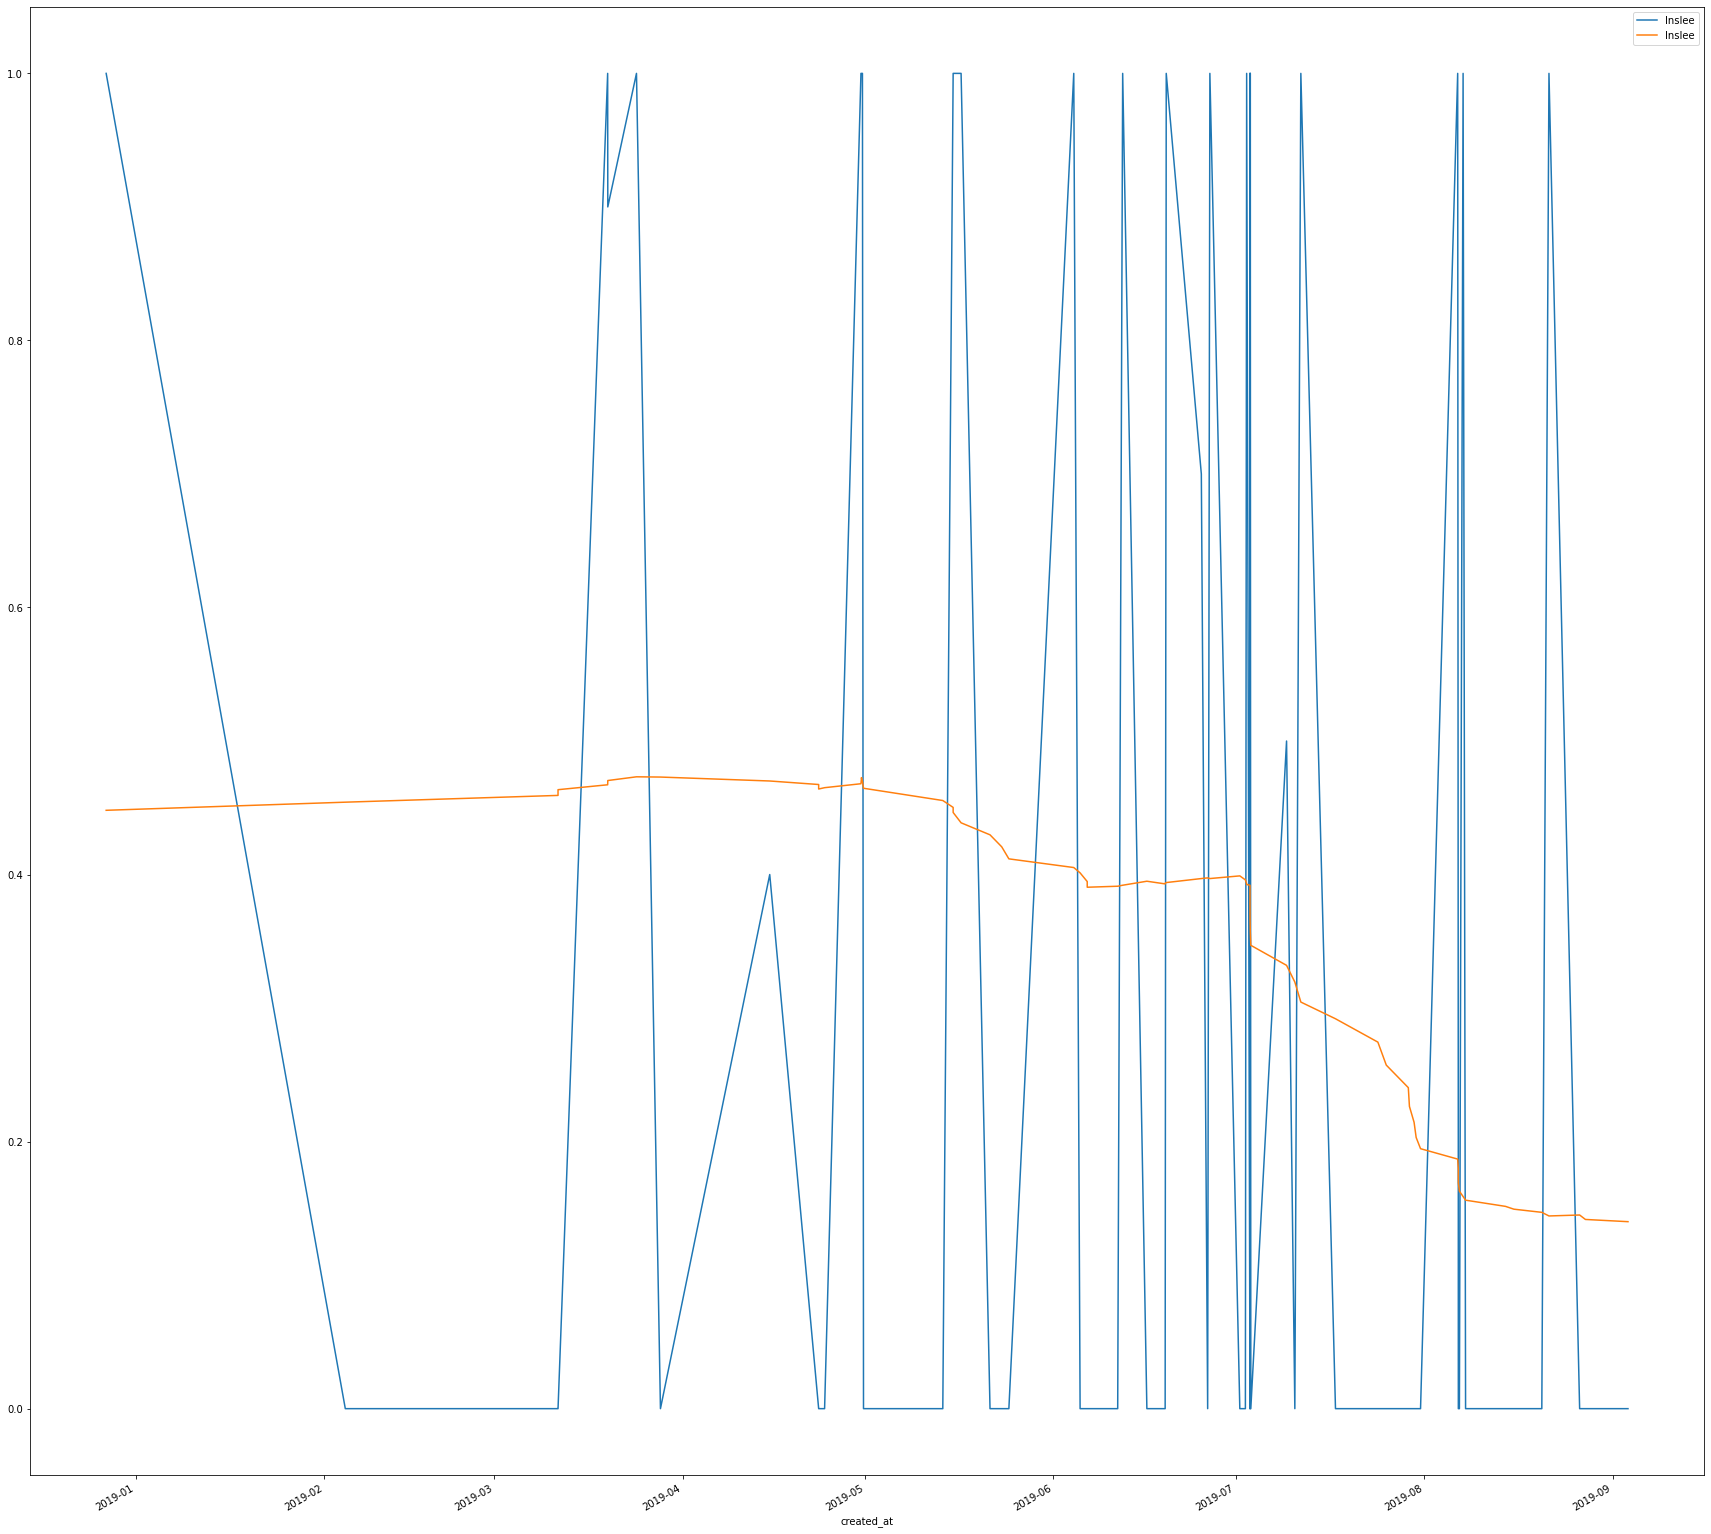

Bullock


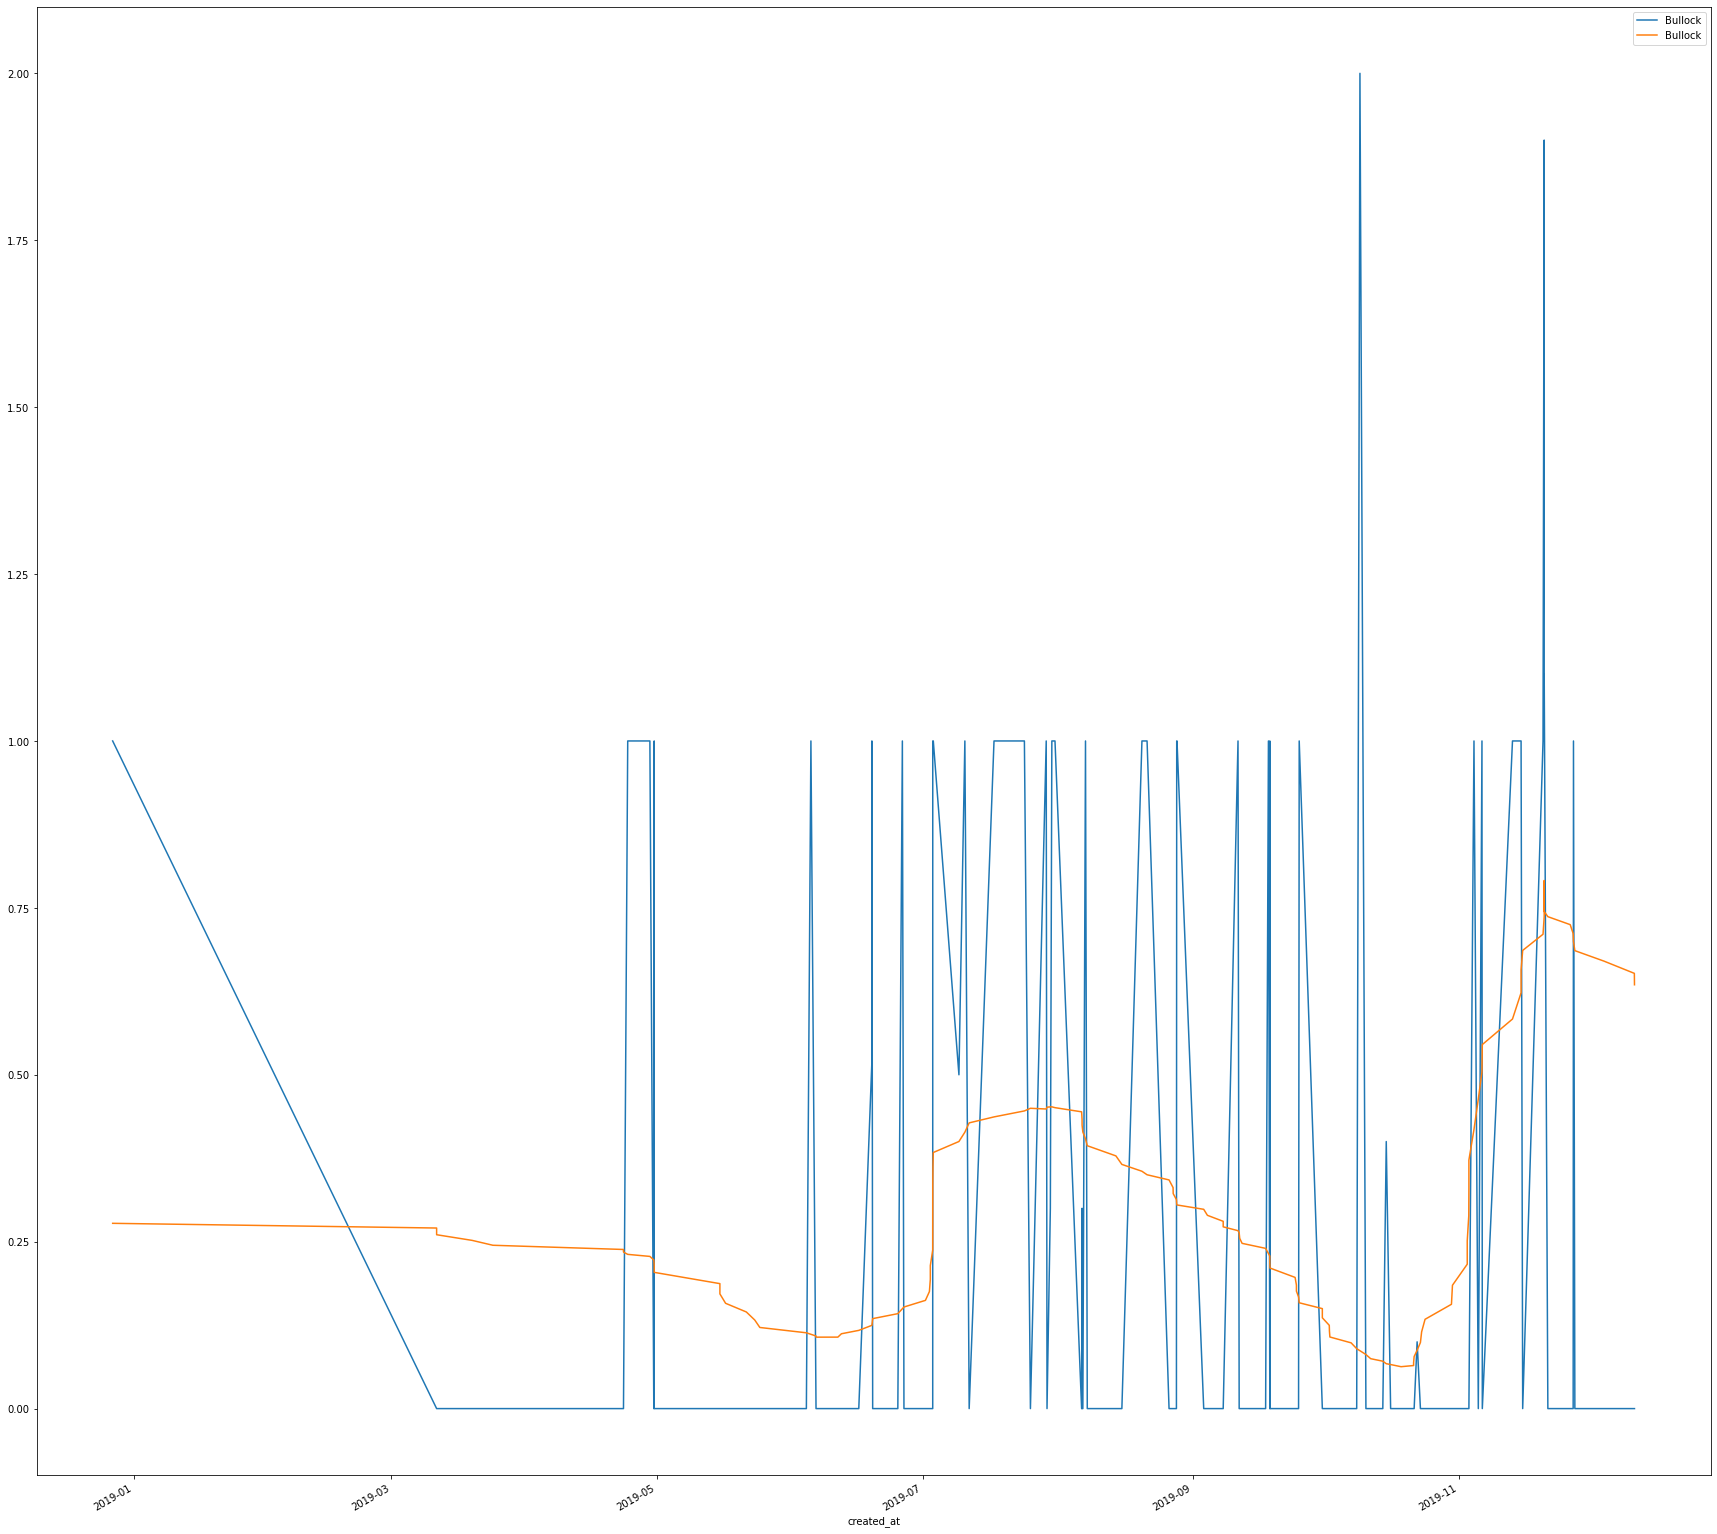

Gillibrand


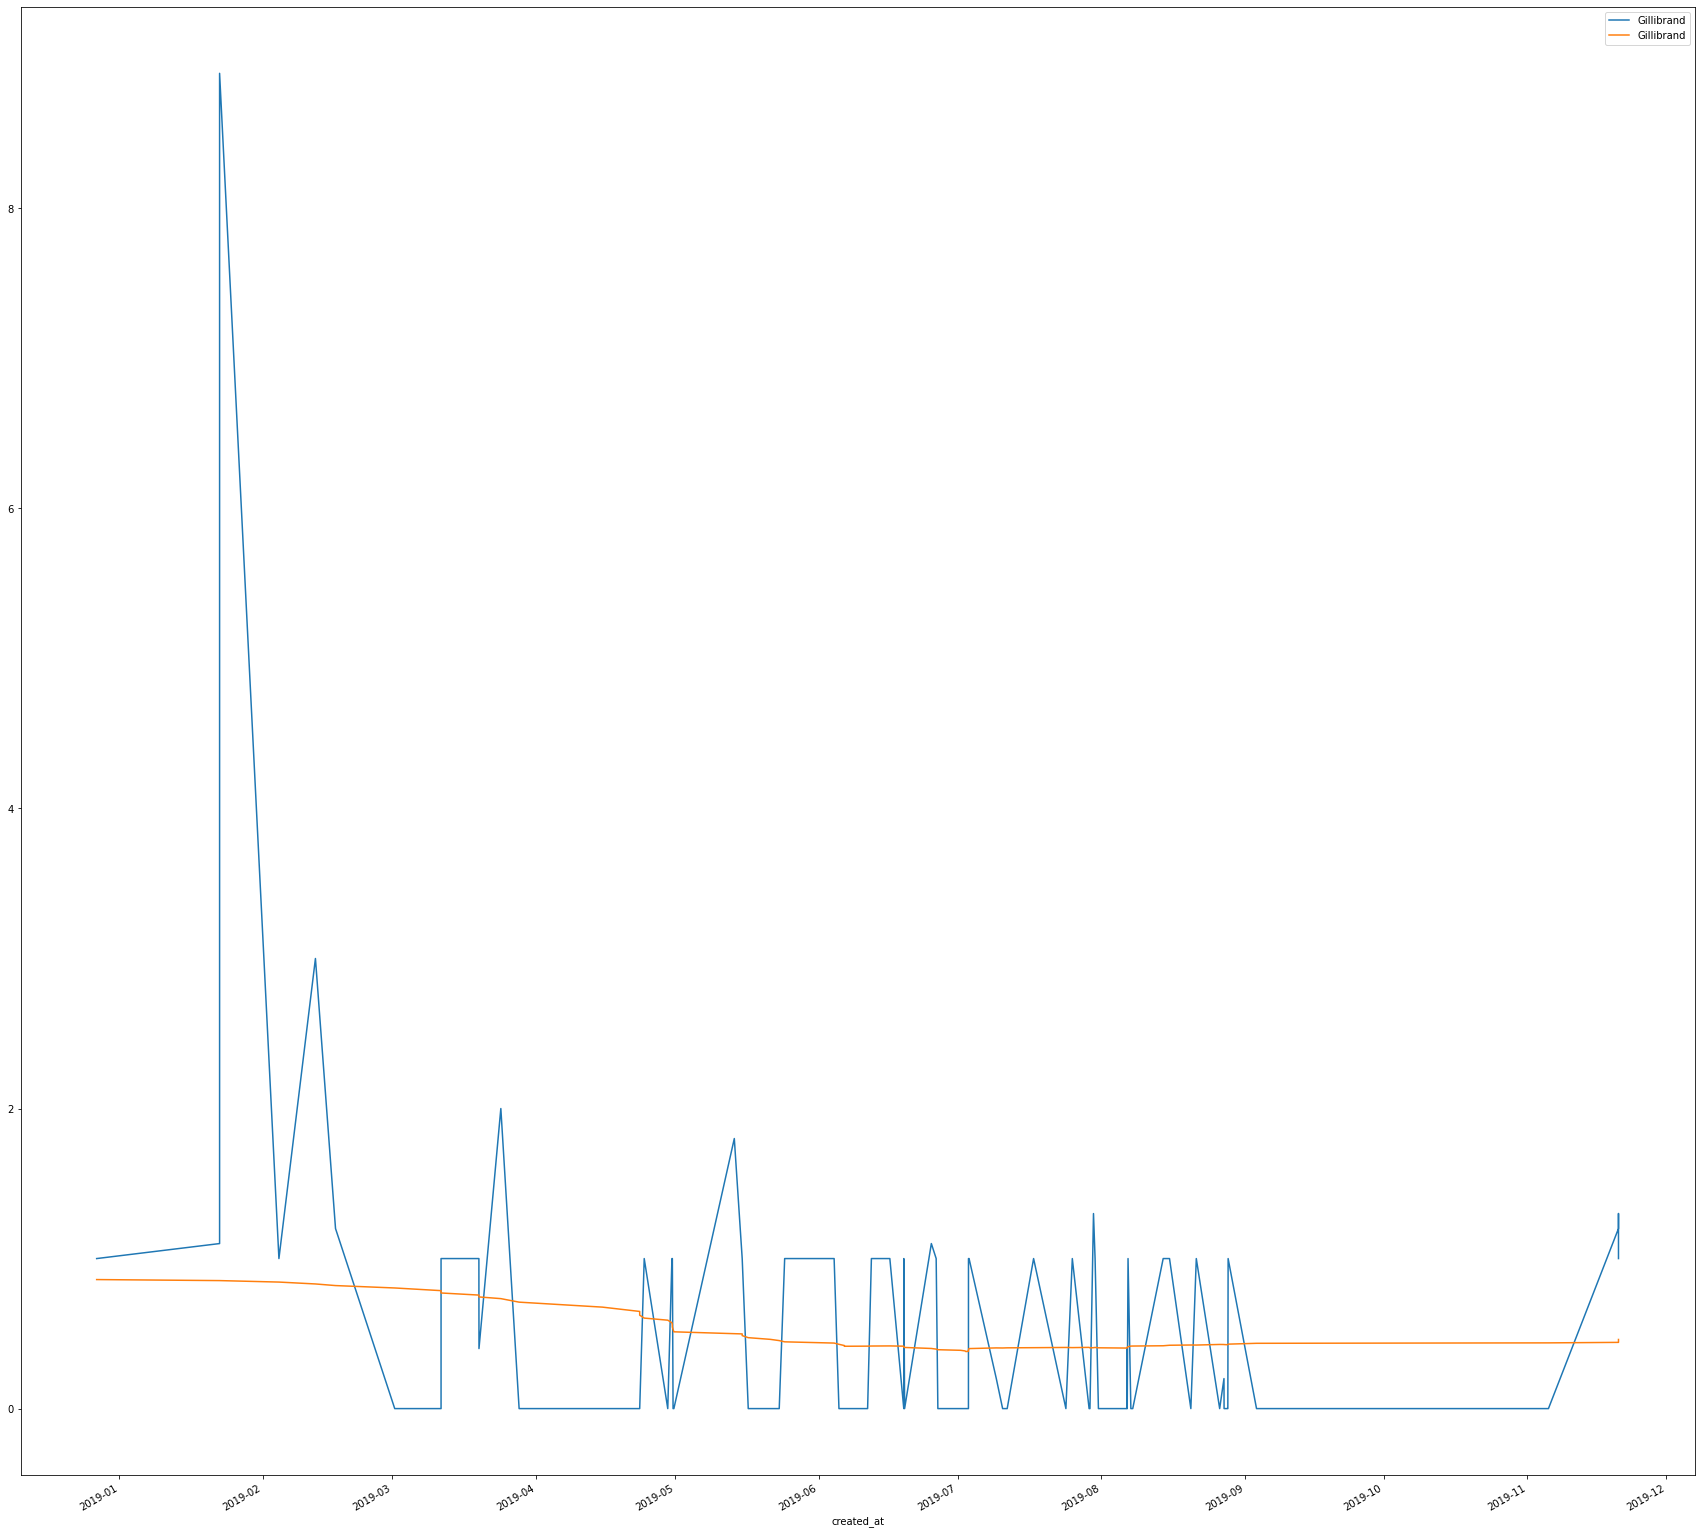

Bloomberg


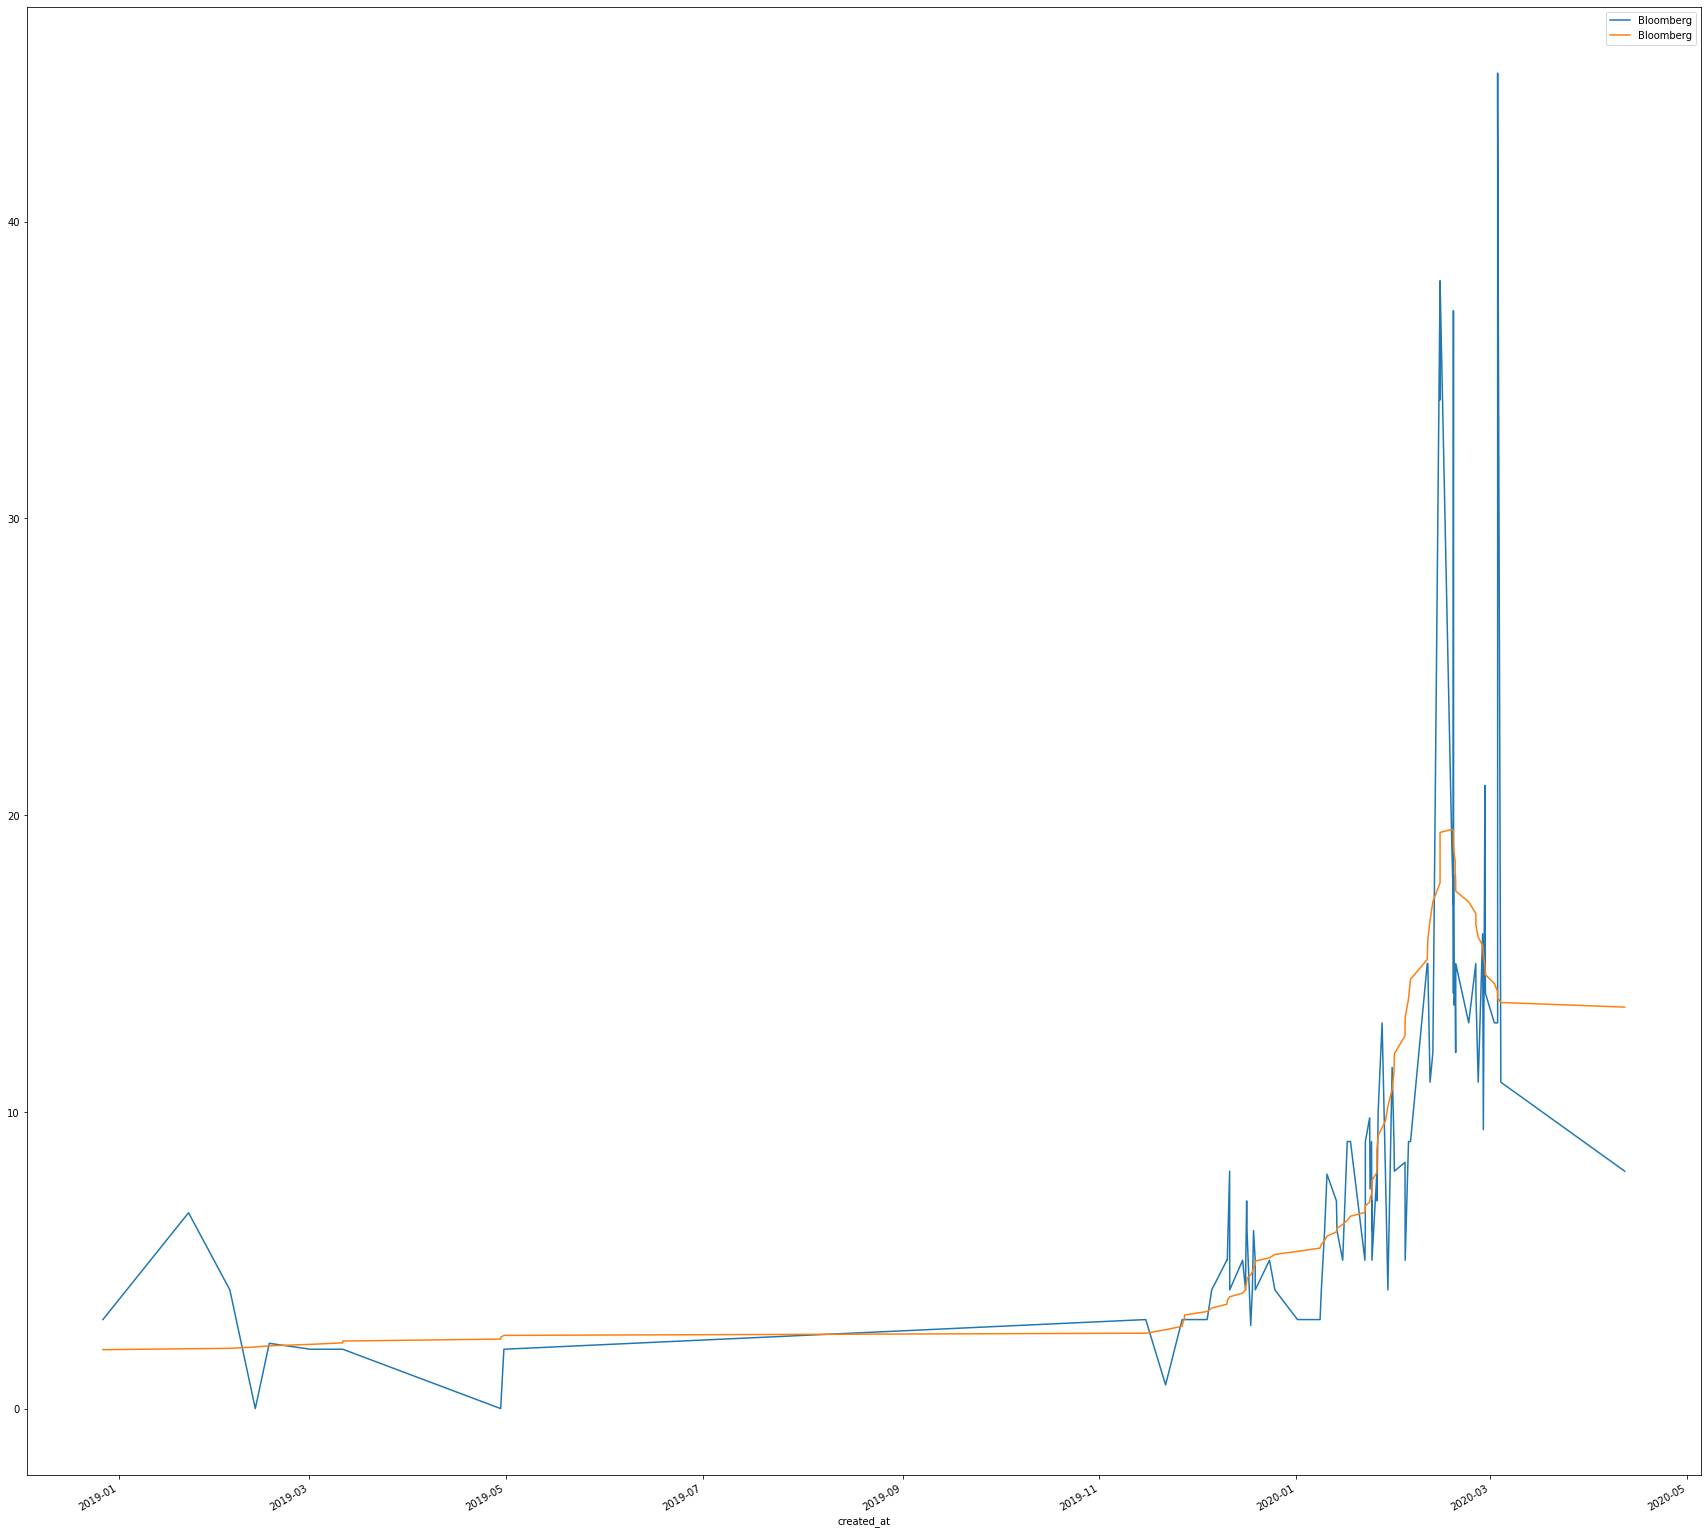

Delaney


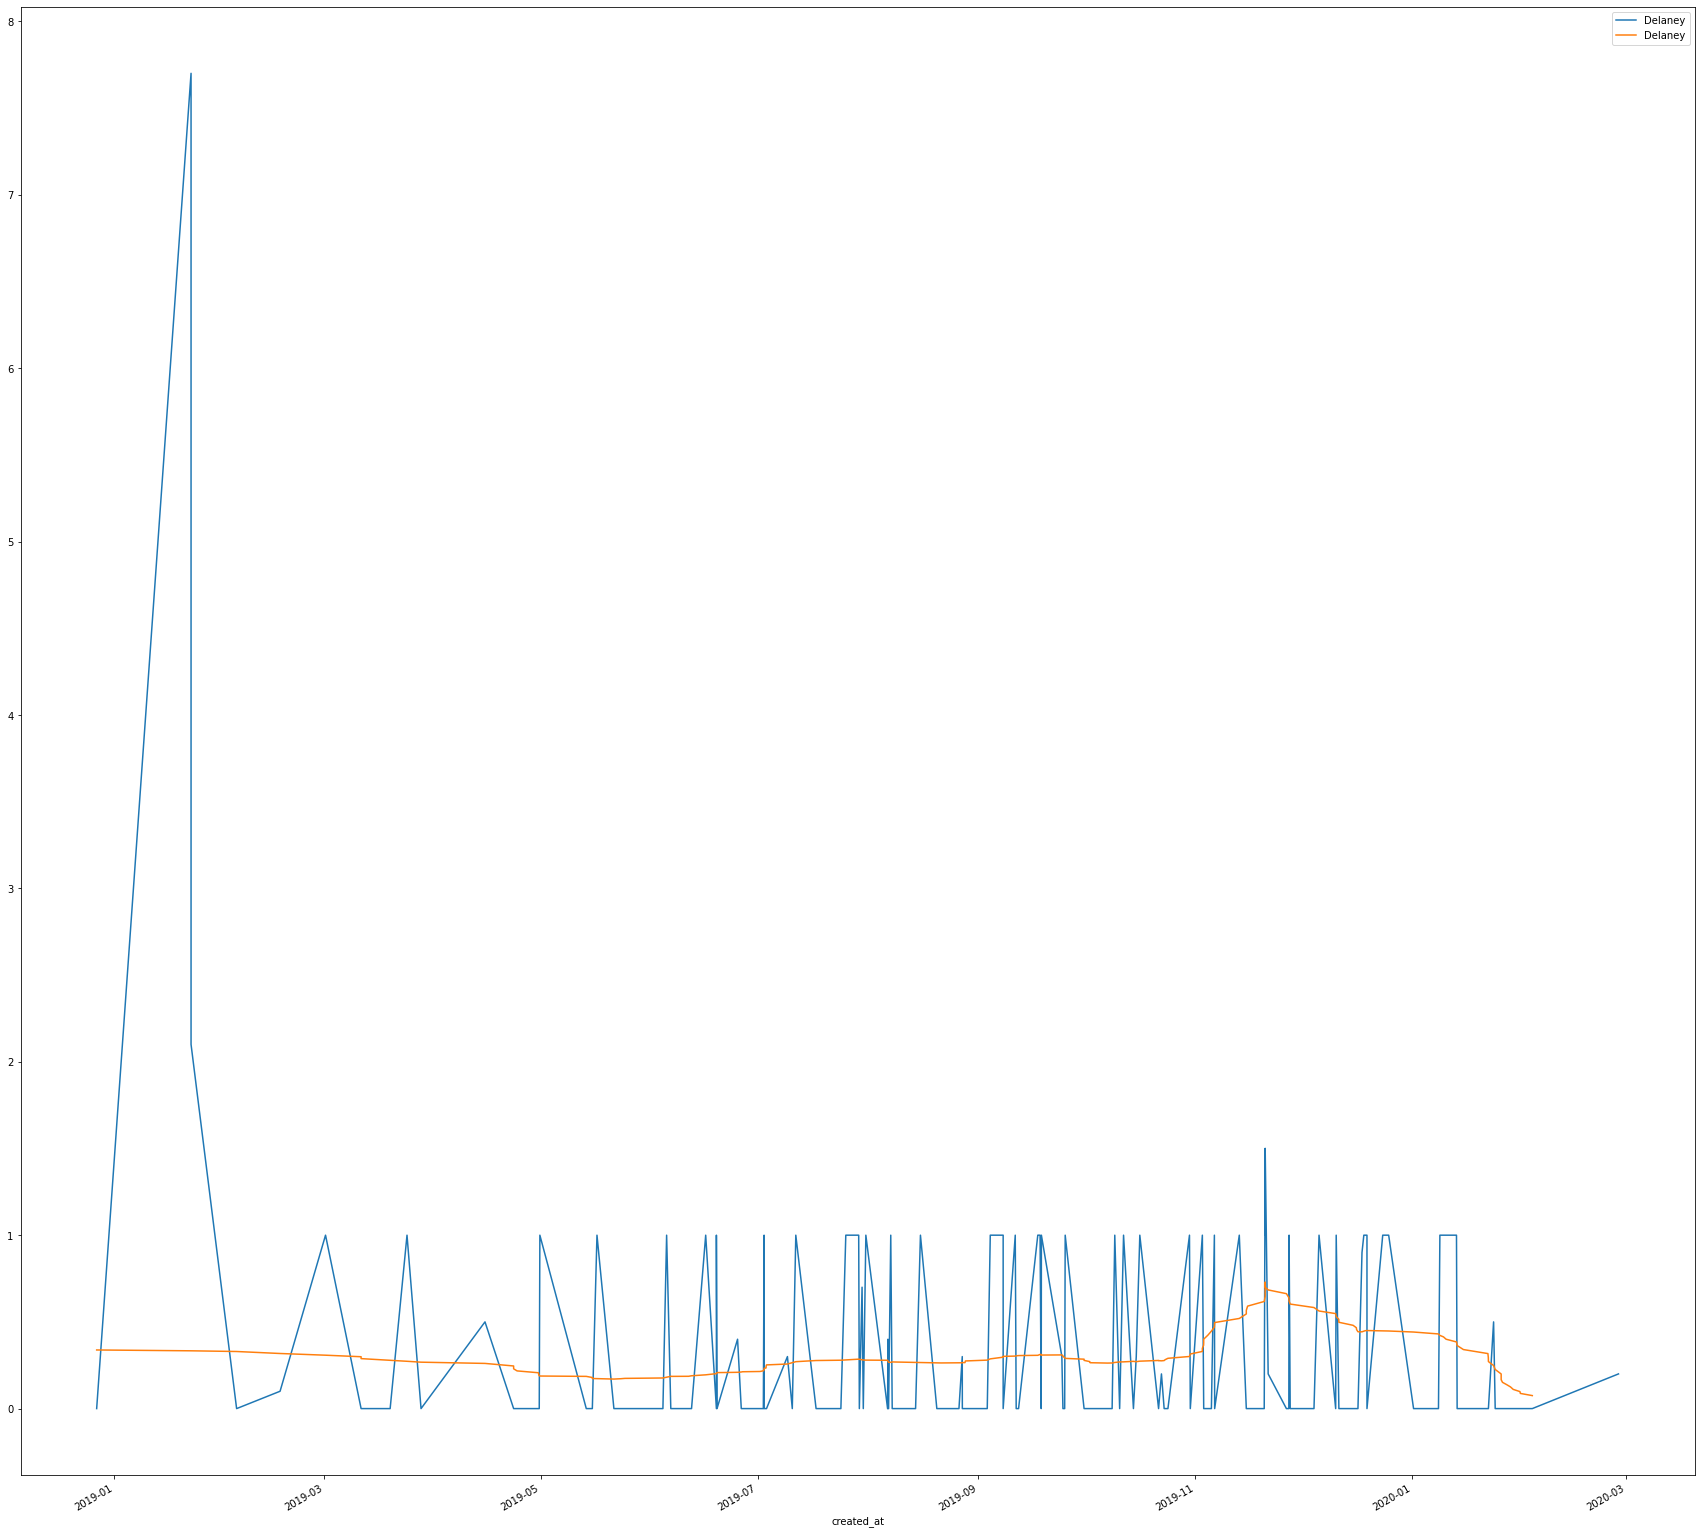

Booker


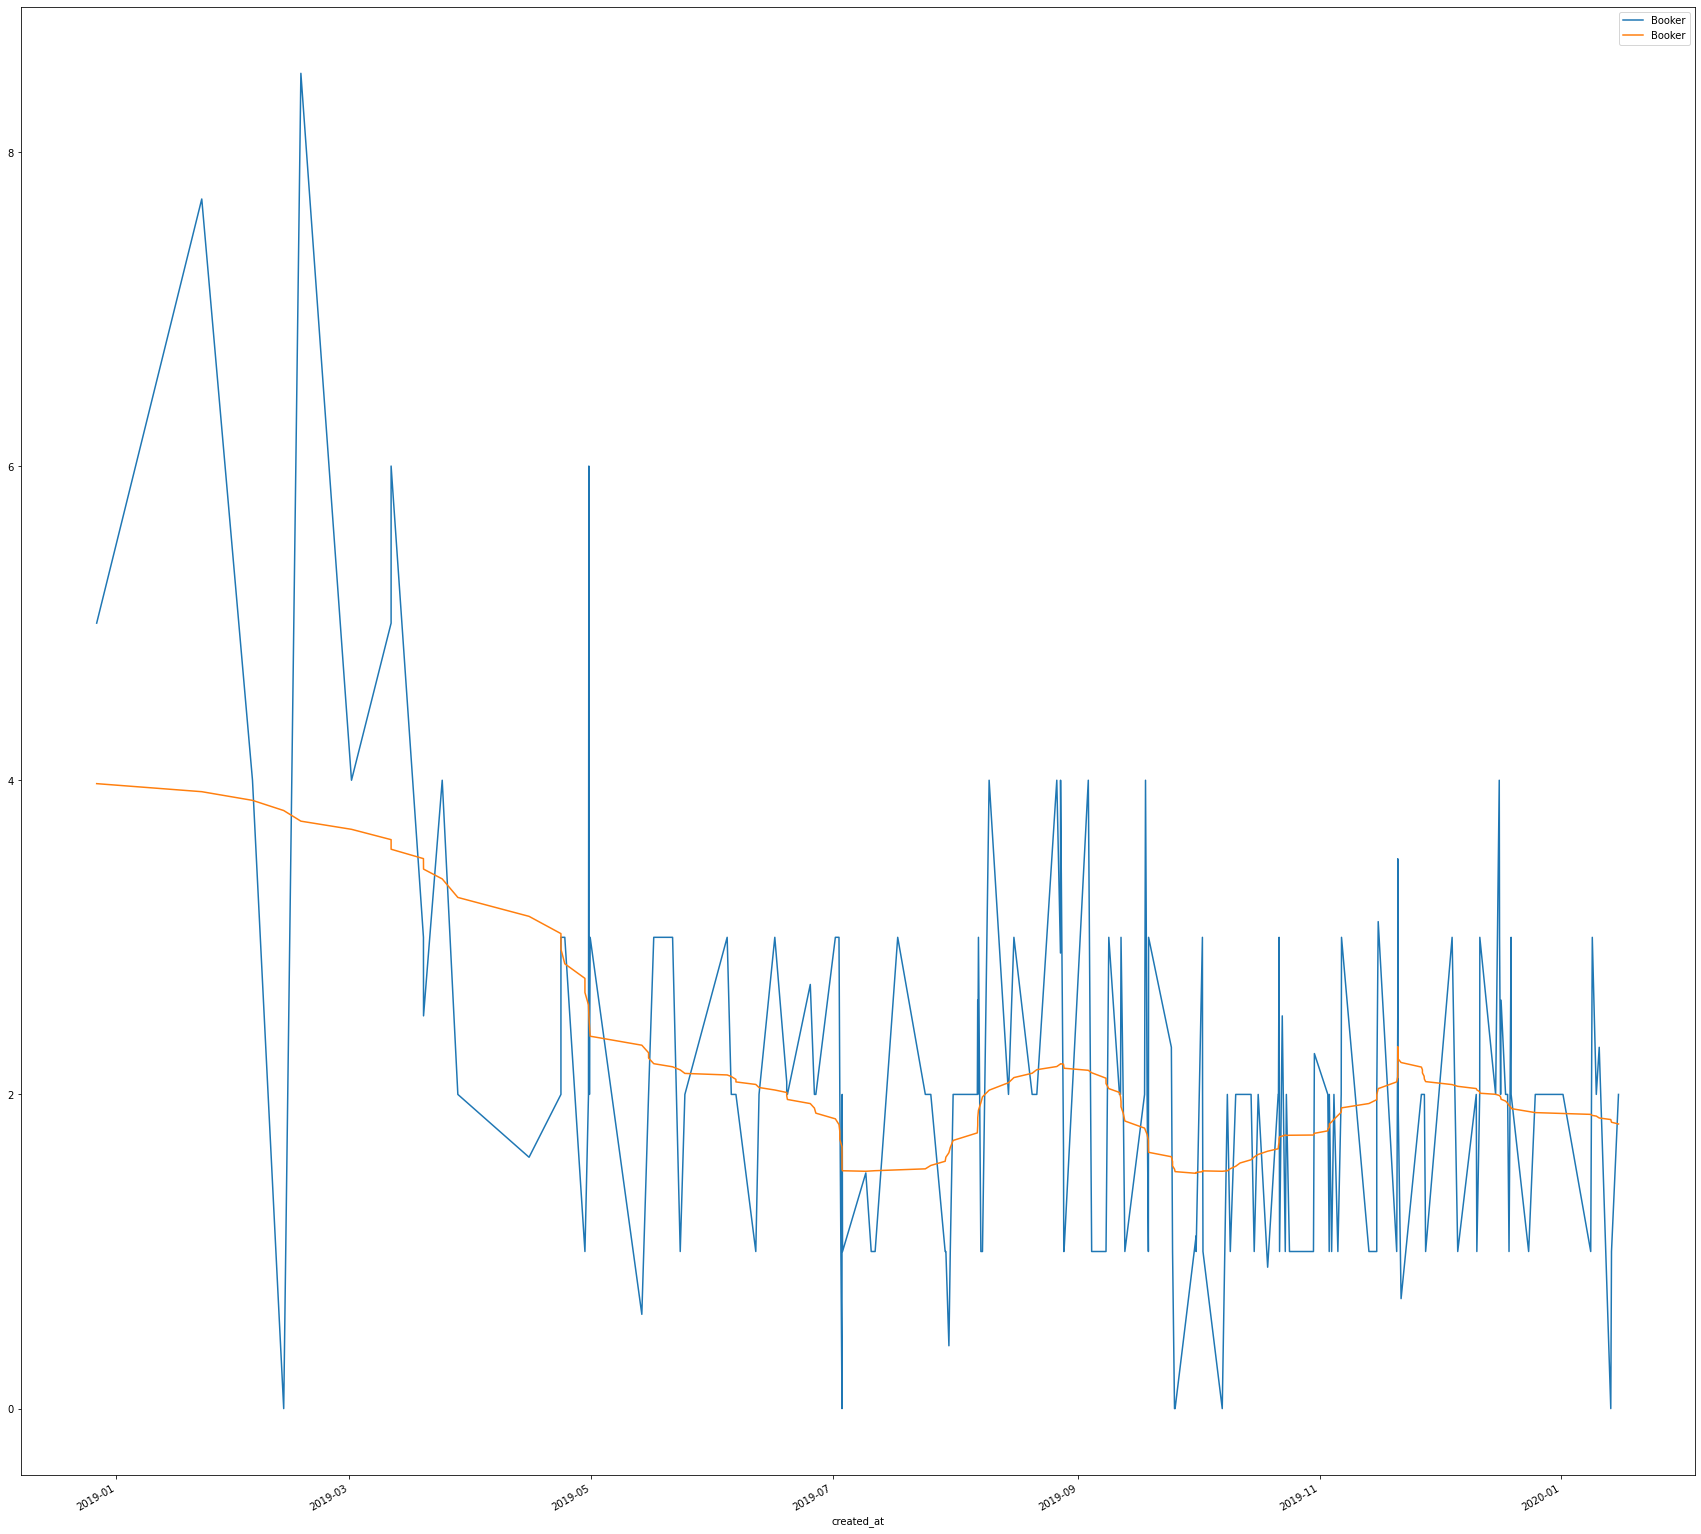

Klobuchar


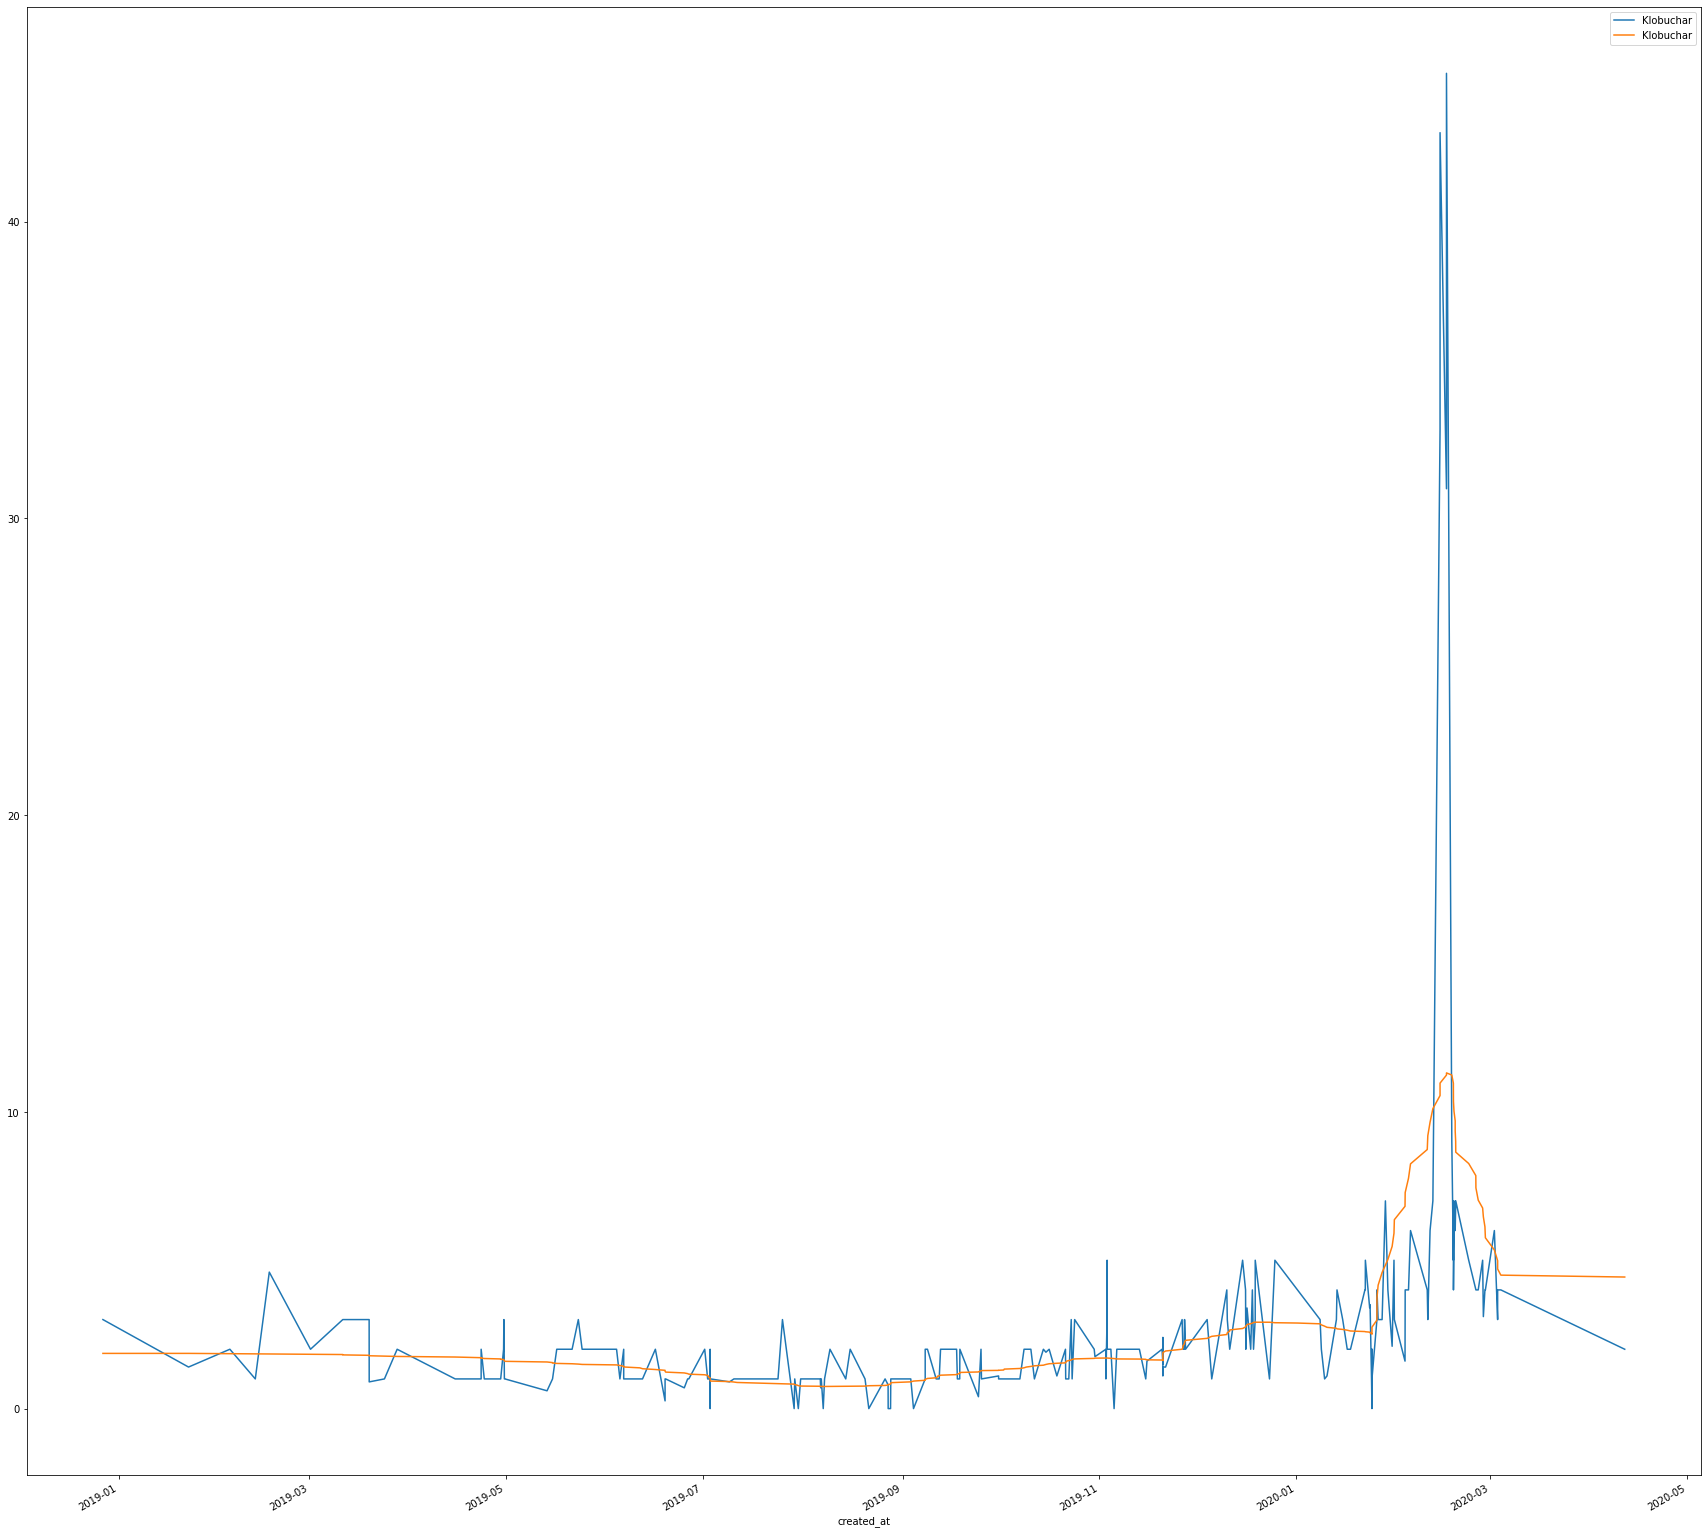

Steyer


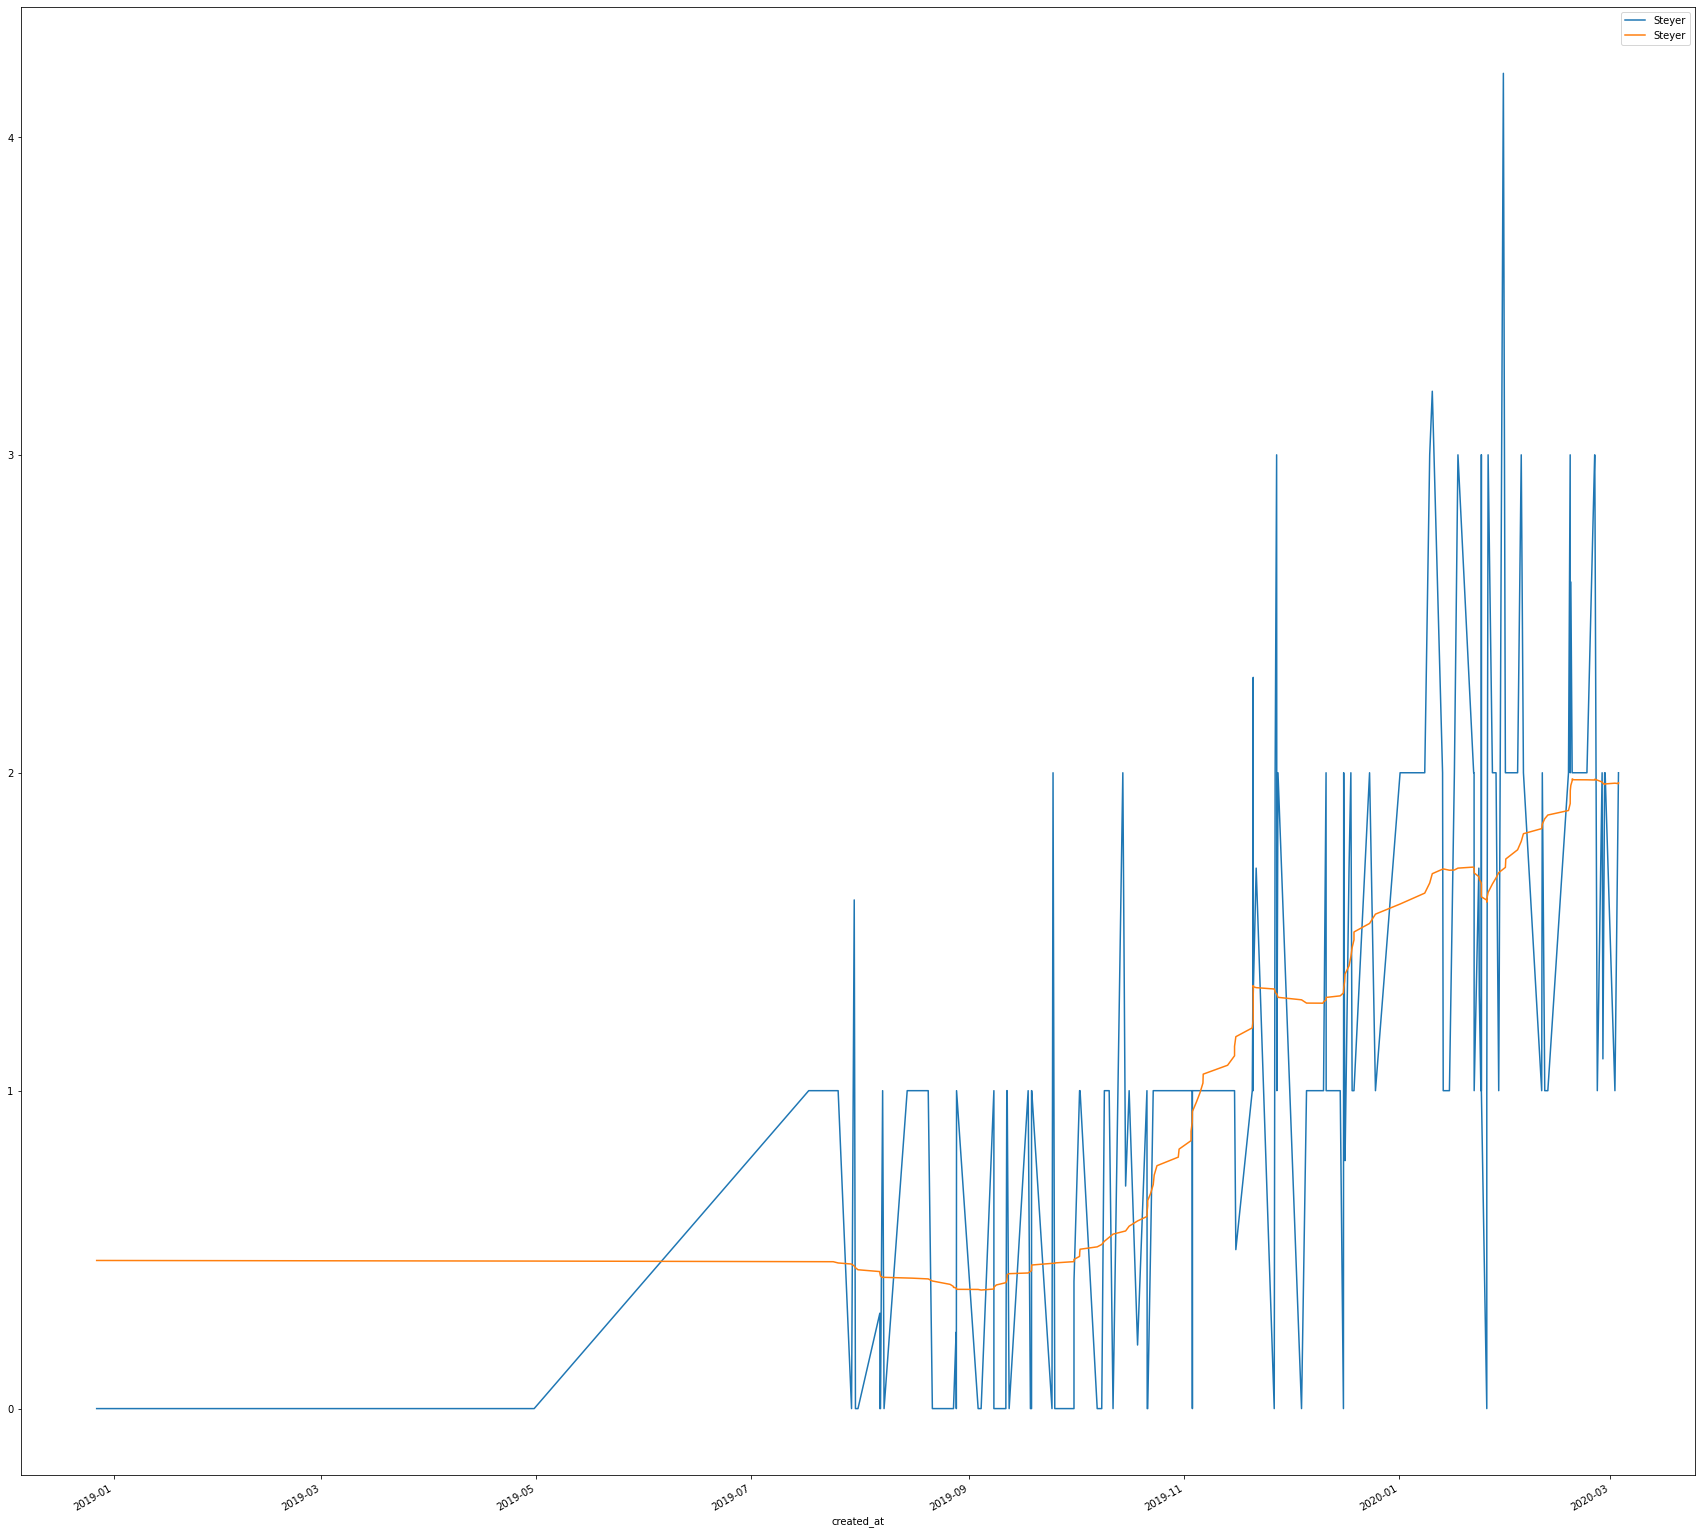

Gabbard


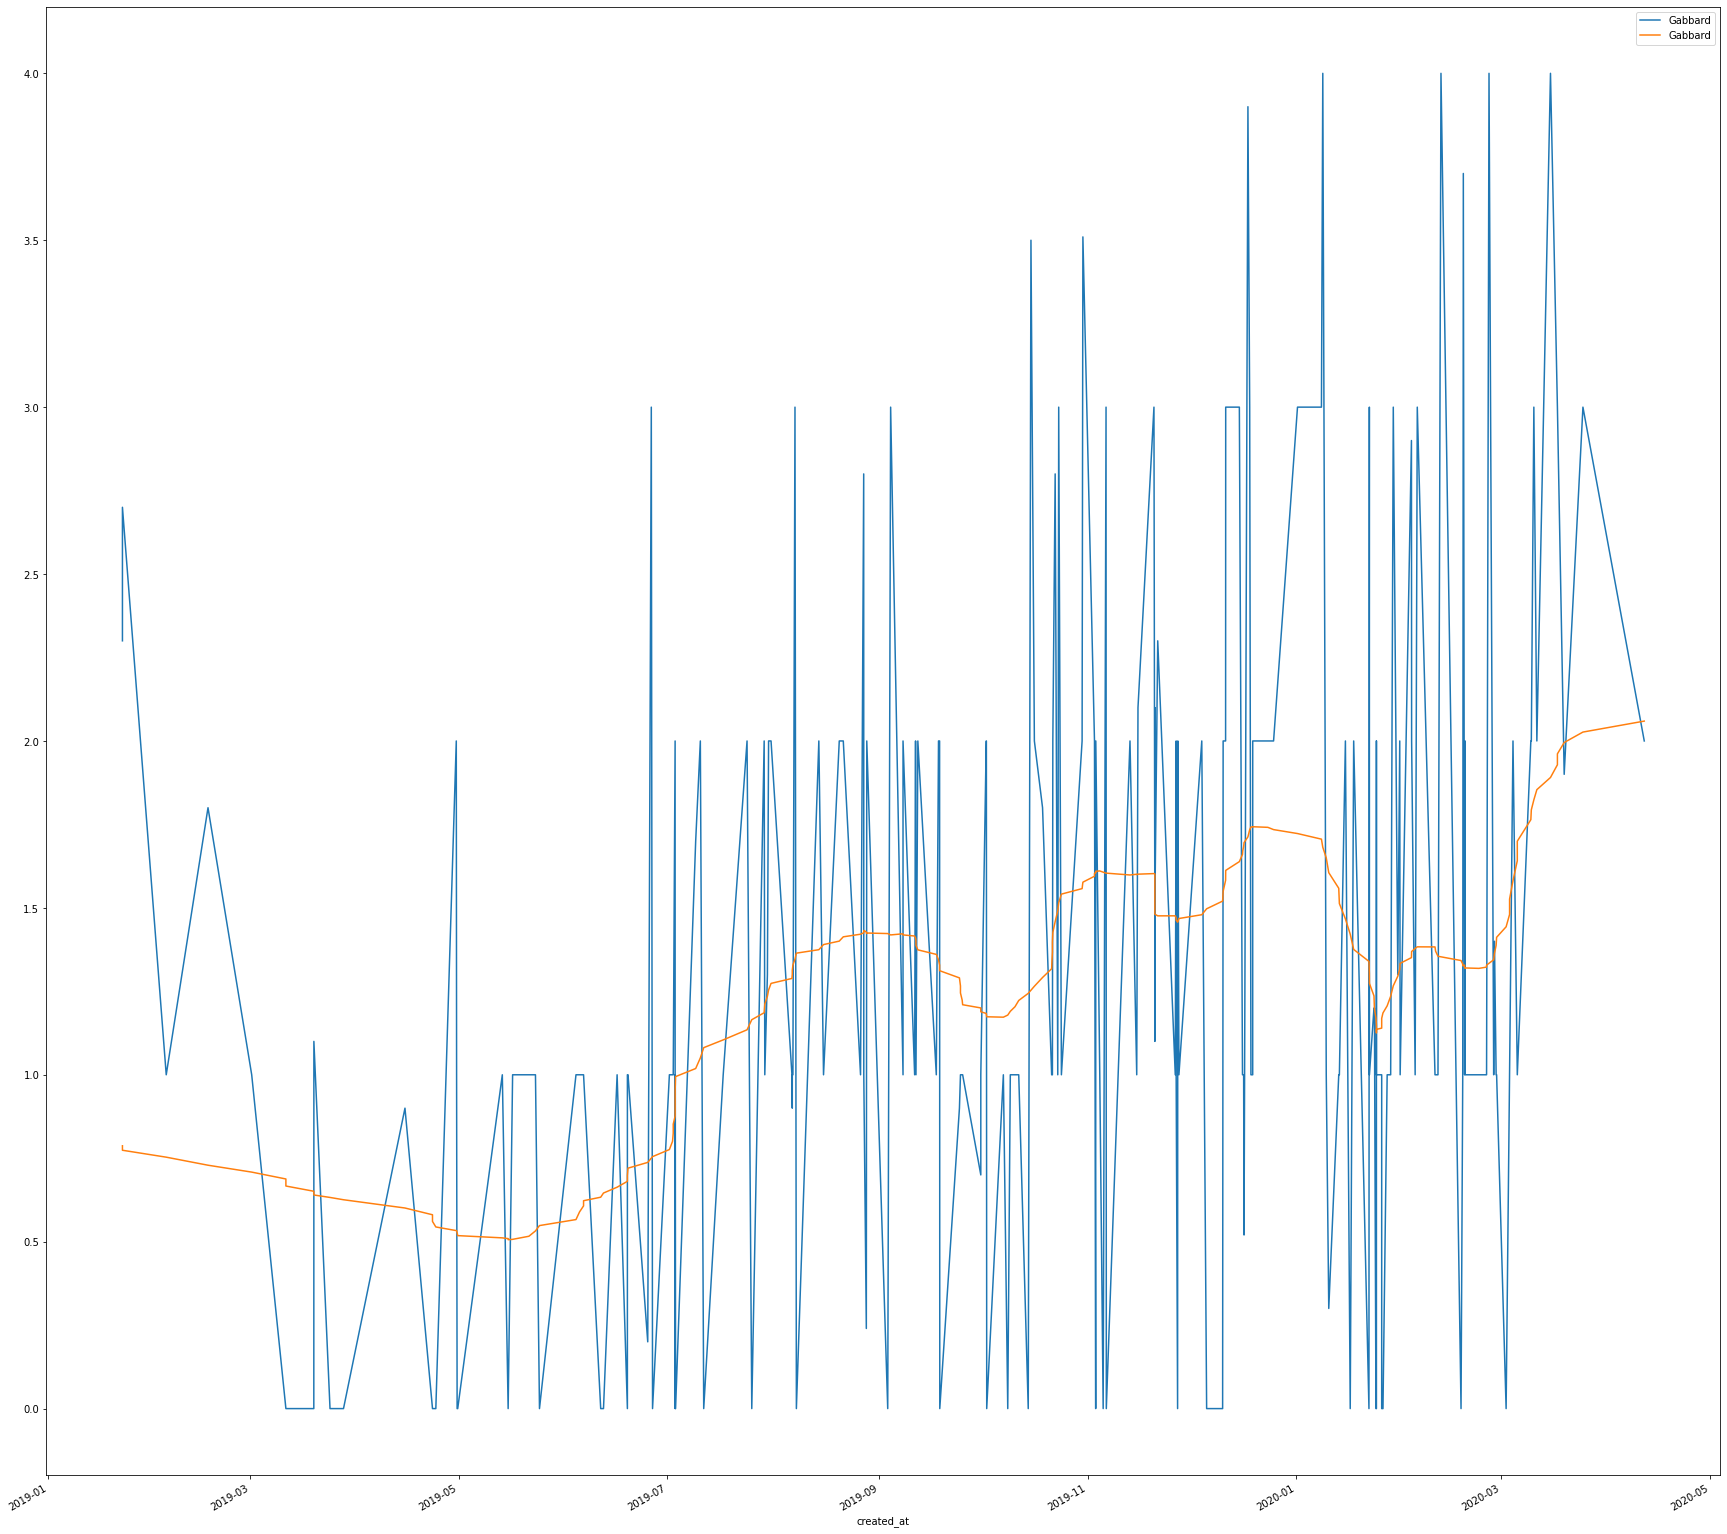

Yang


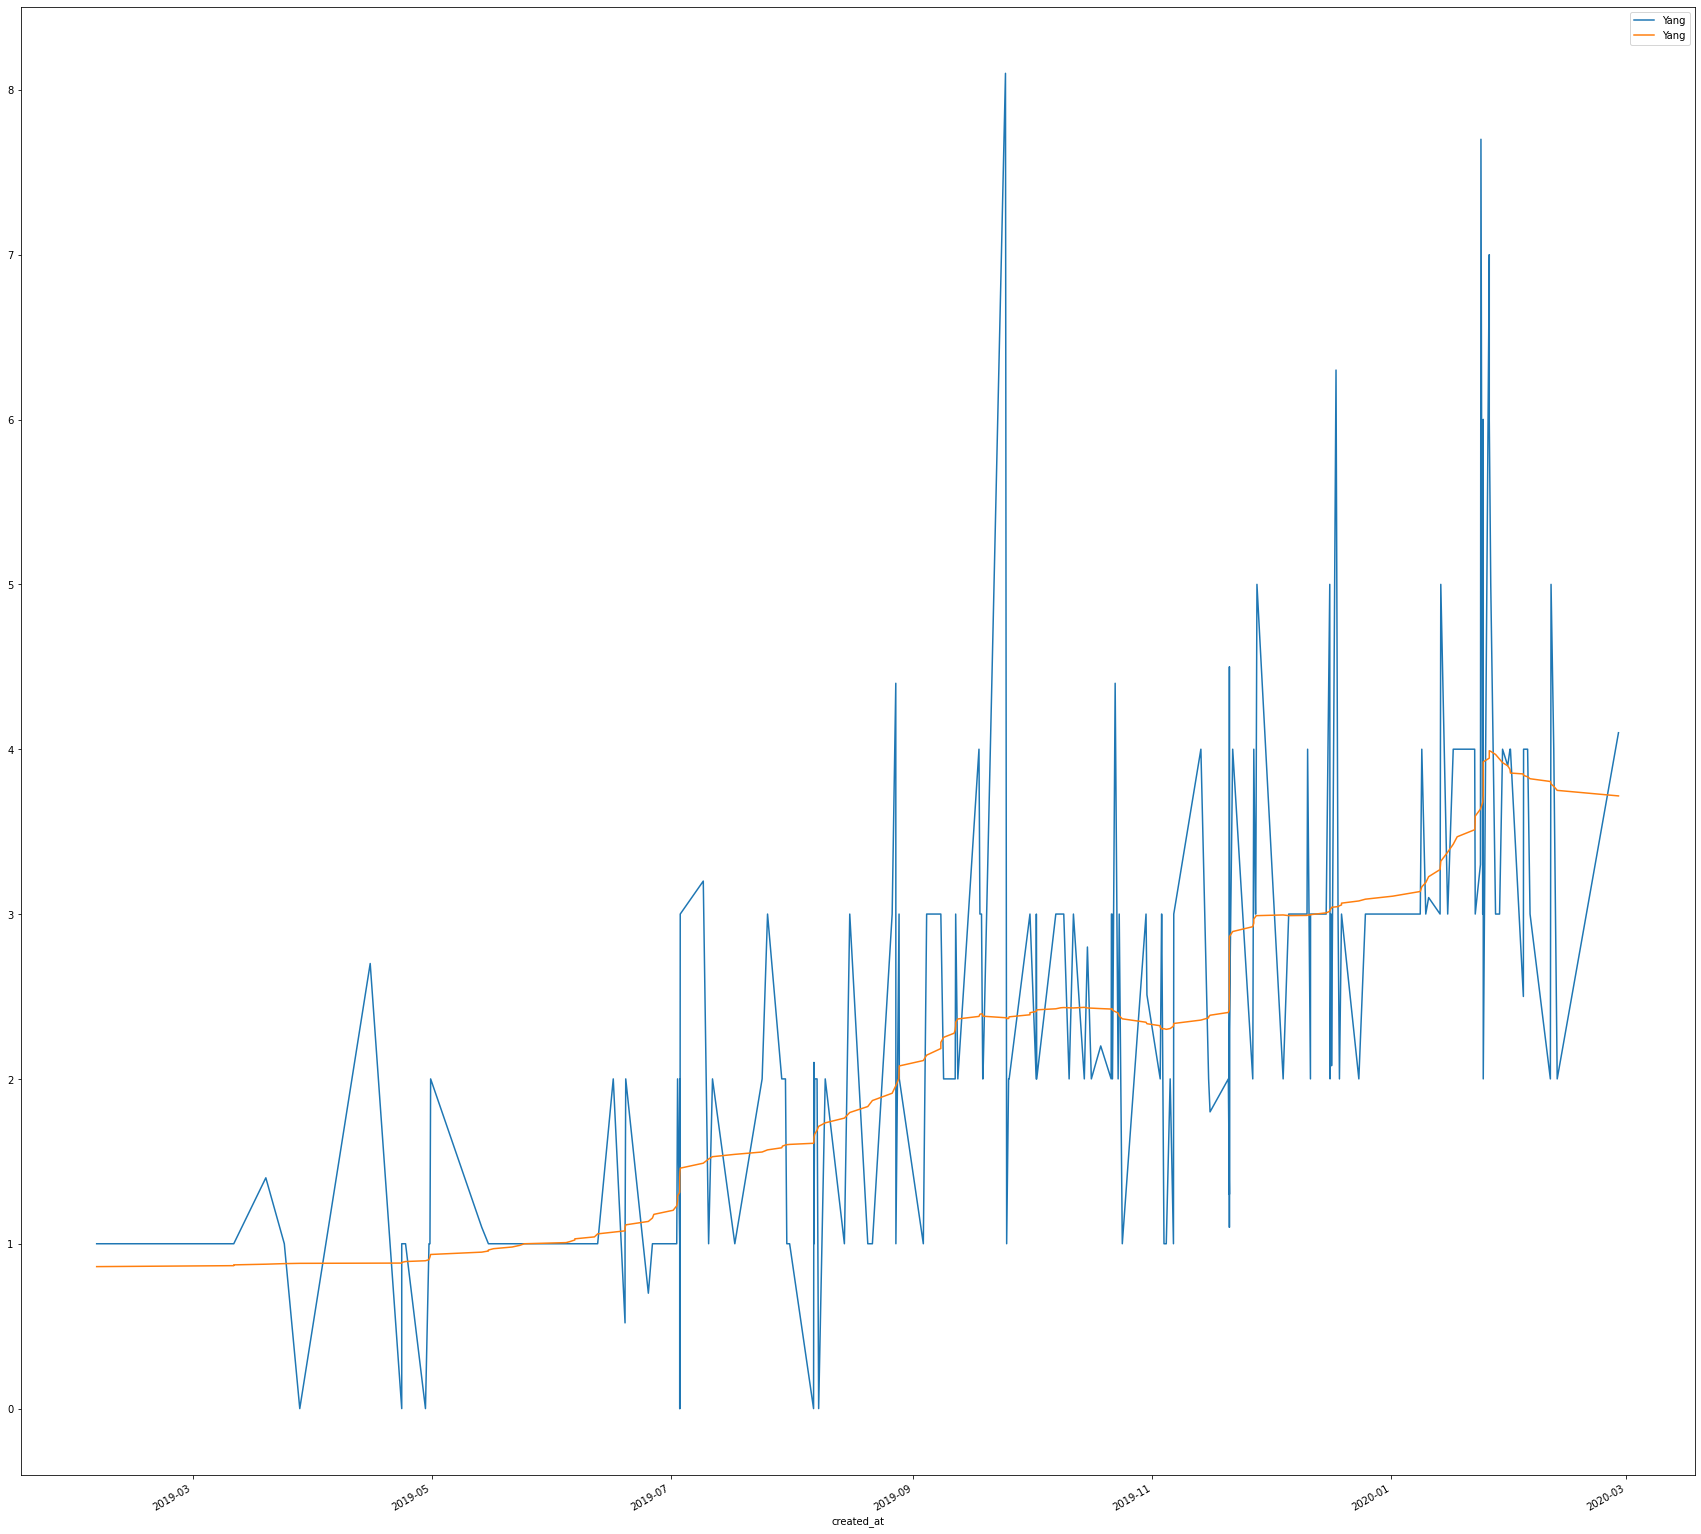

Buttigieg


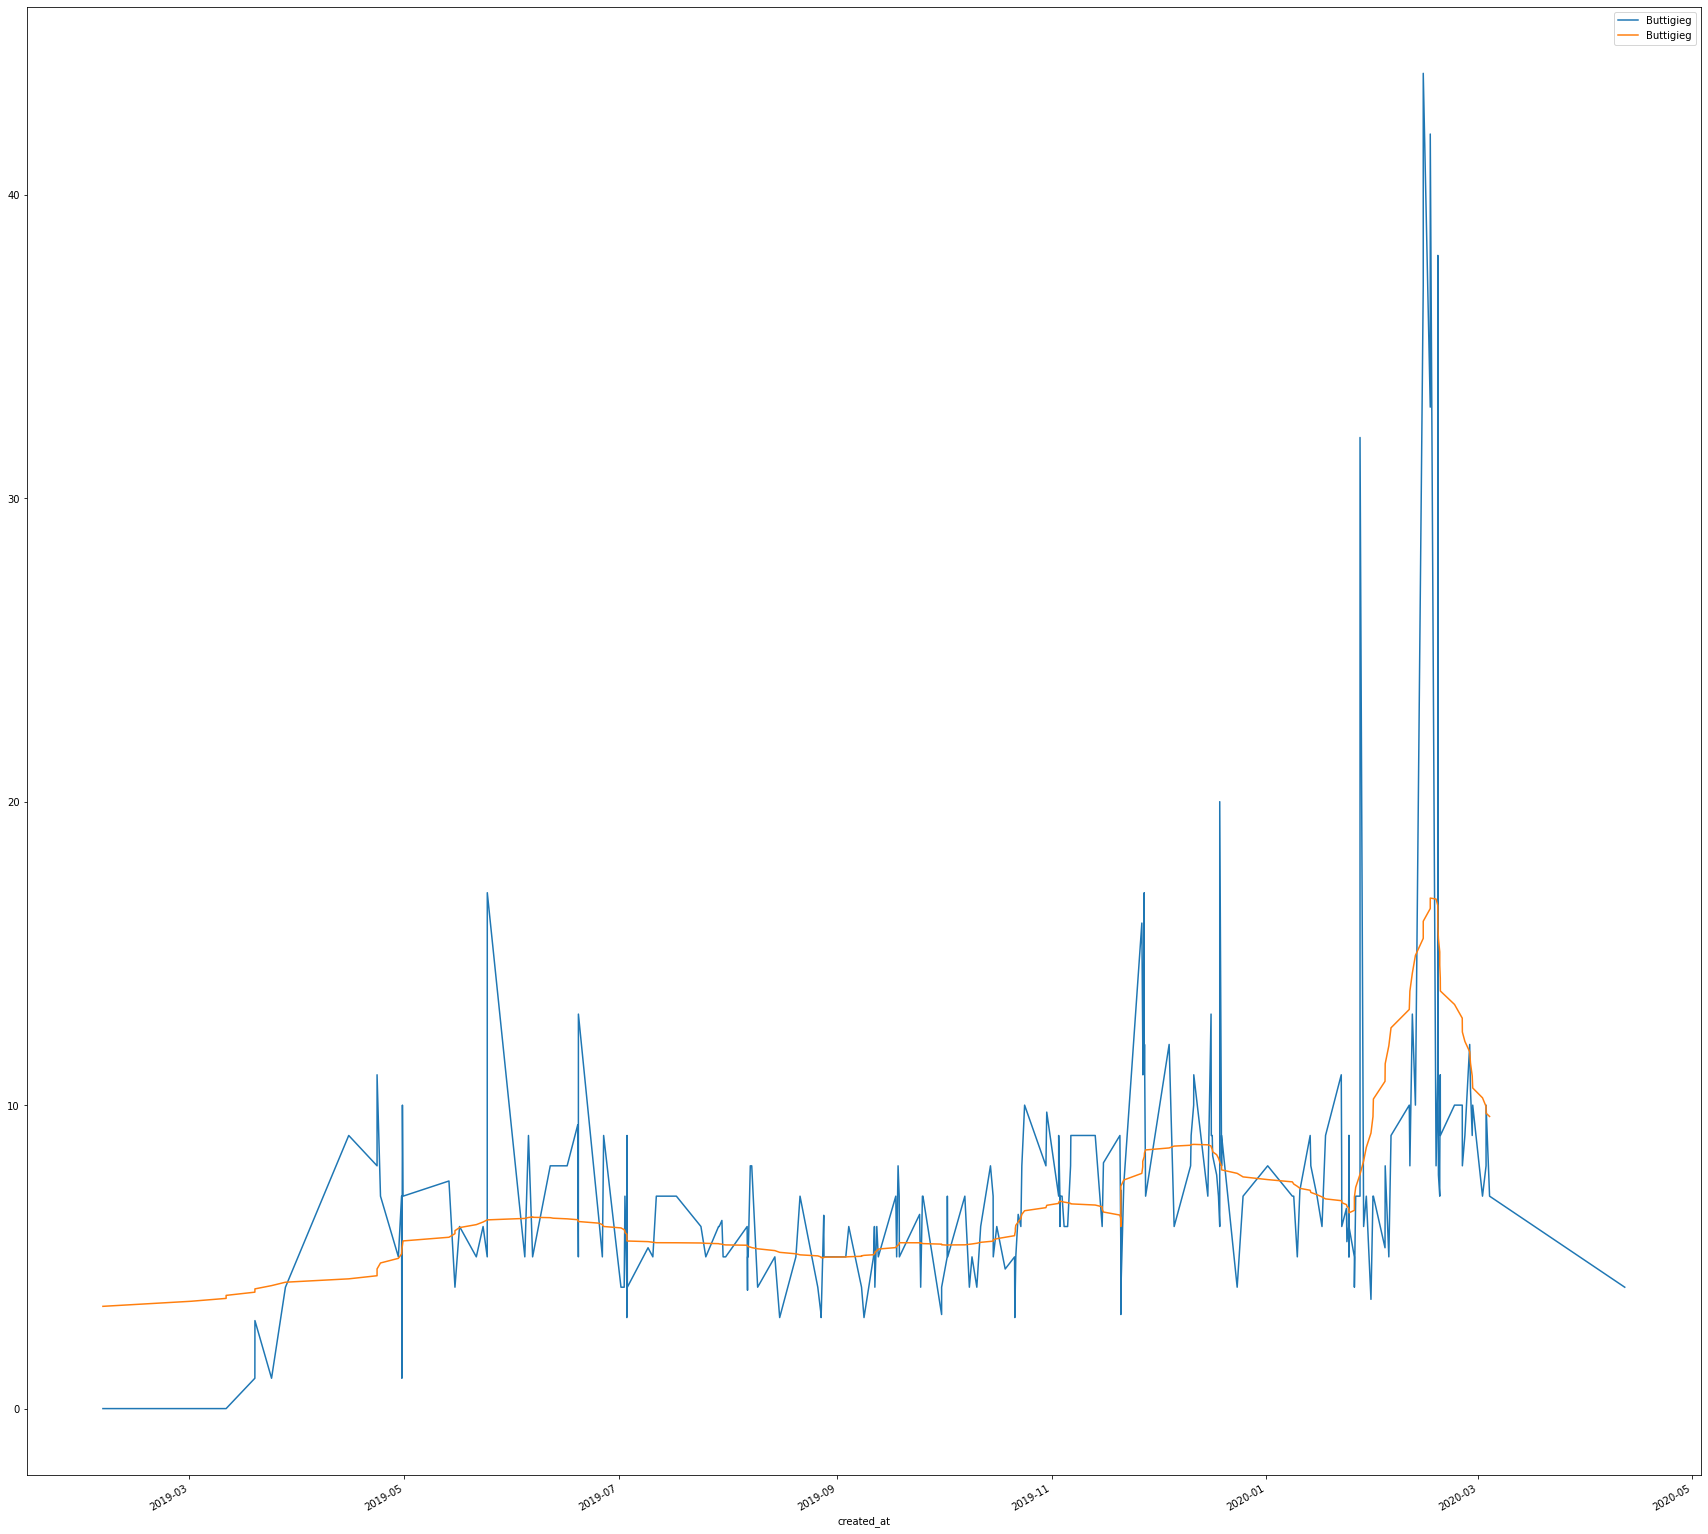

Bennet


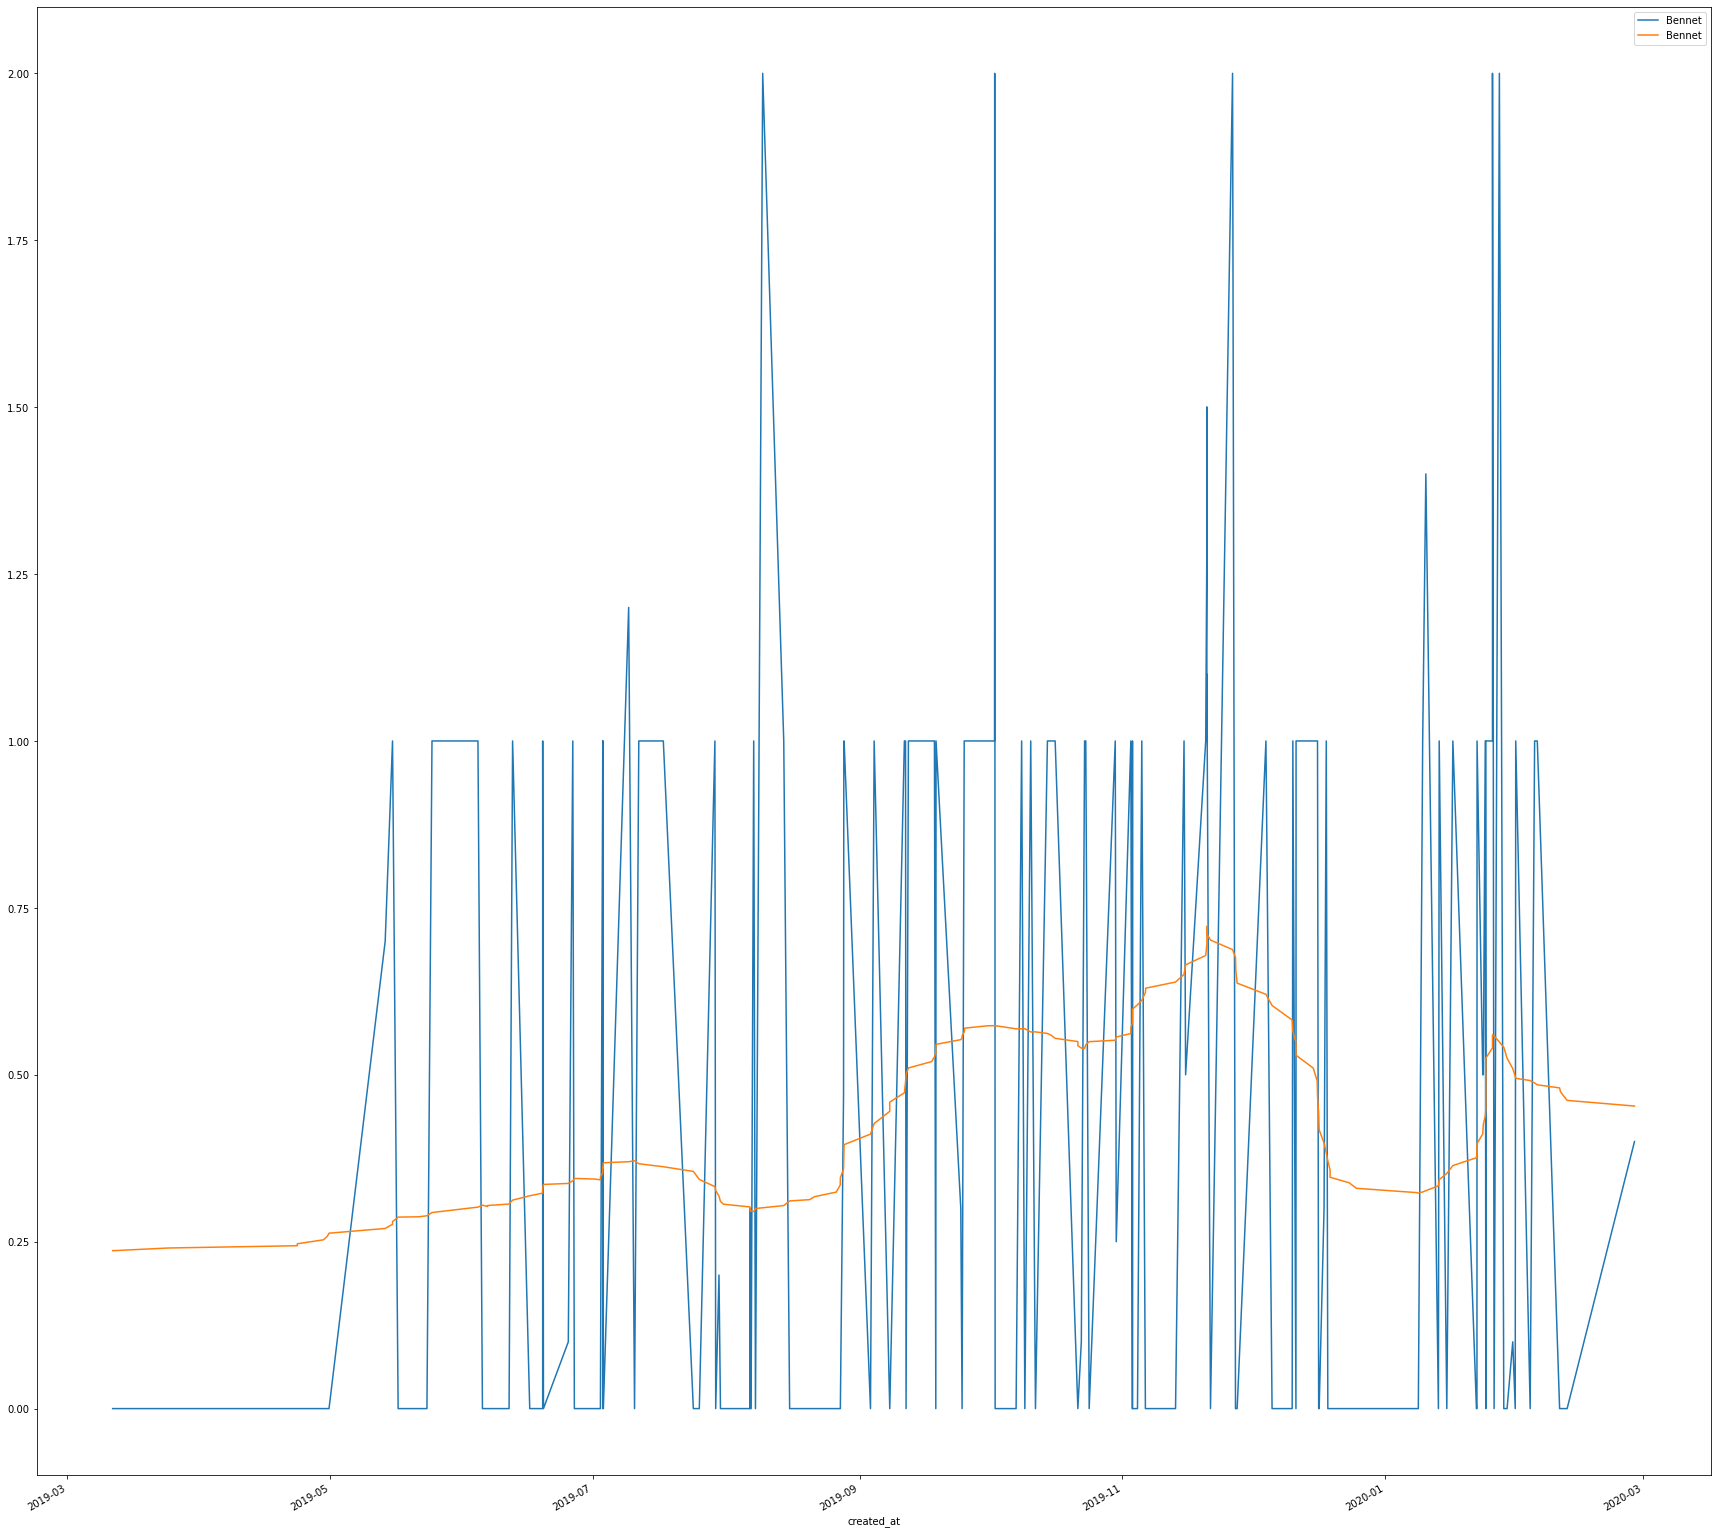

Williamson


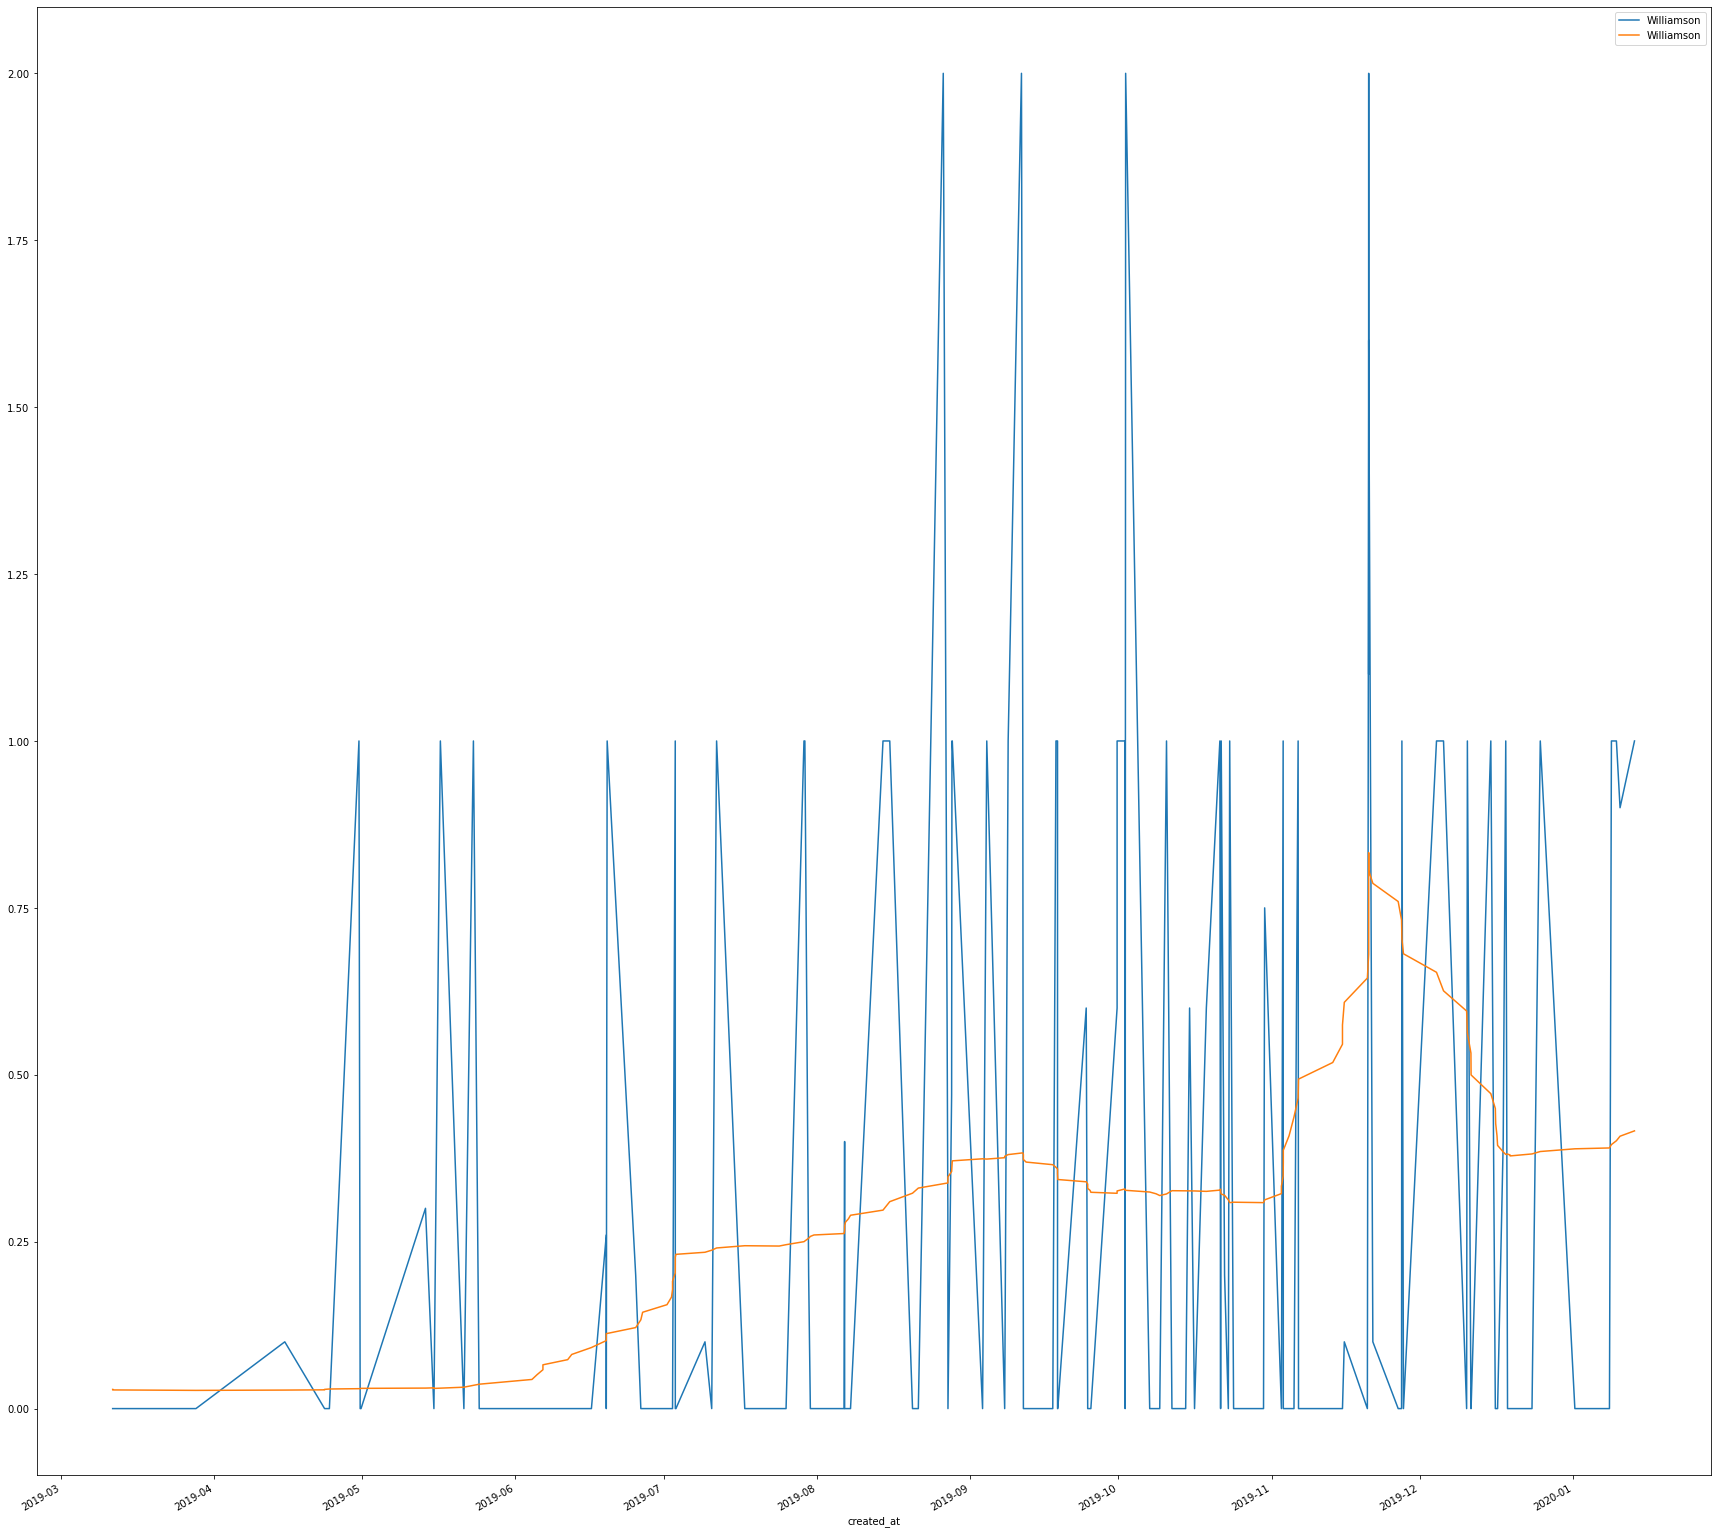

Swalwell


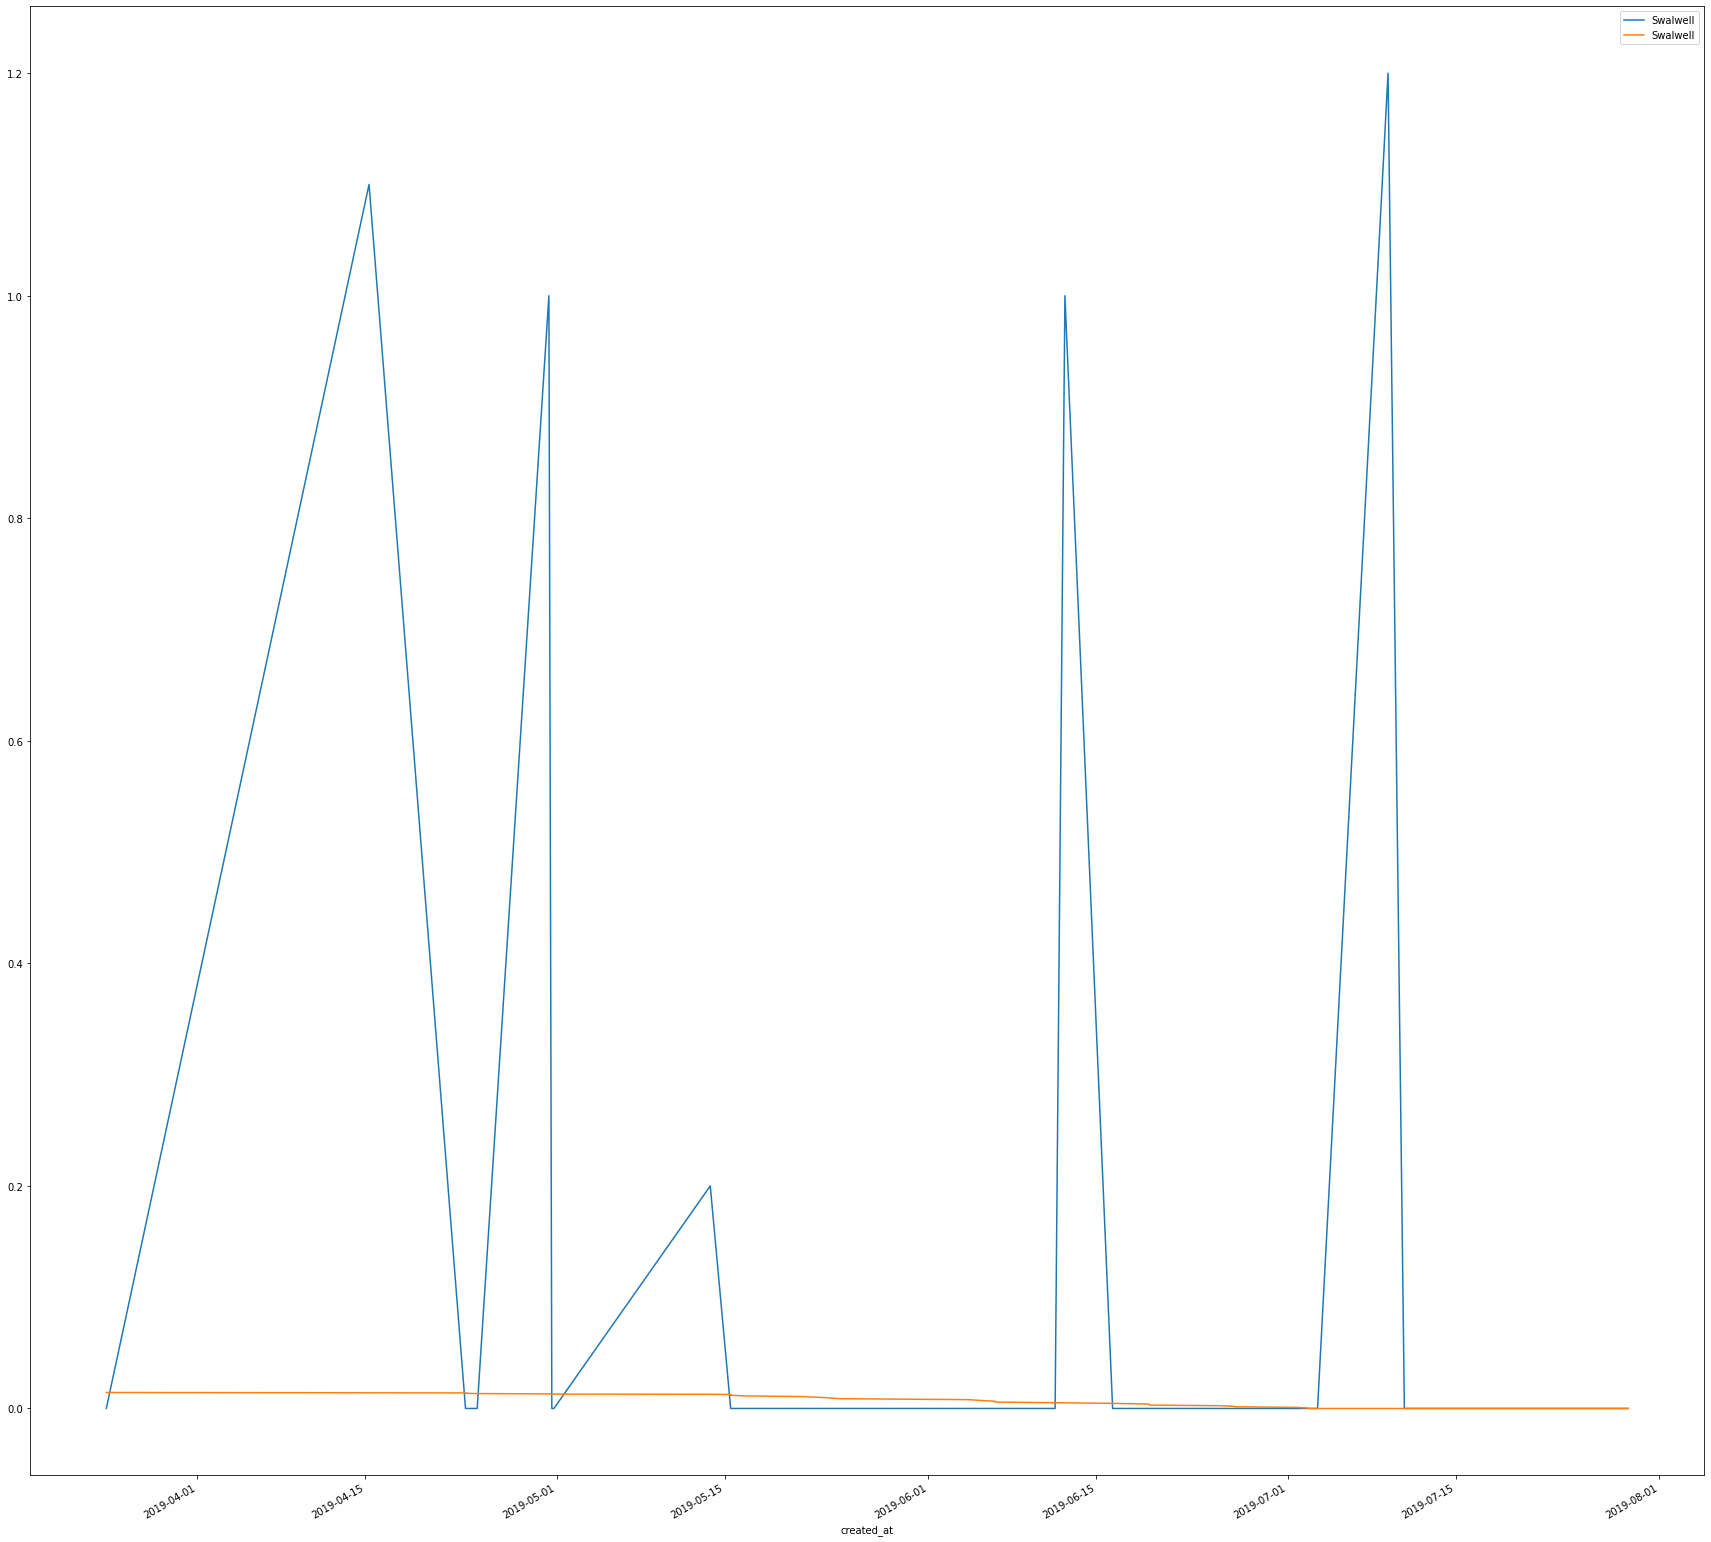

Ryan


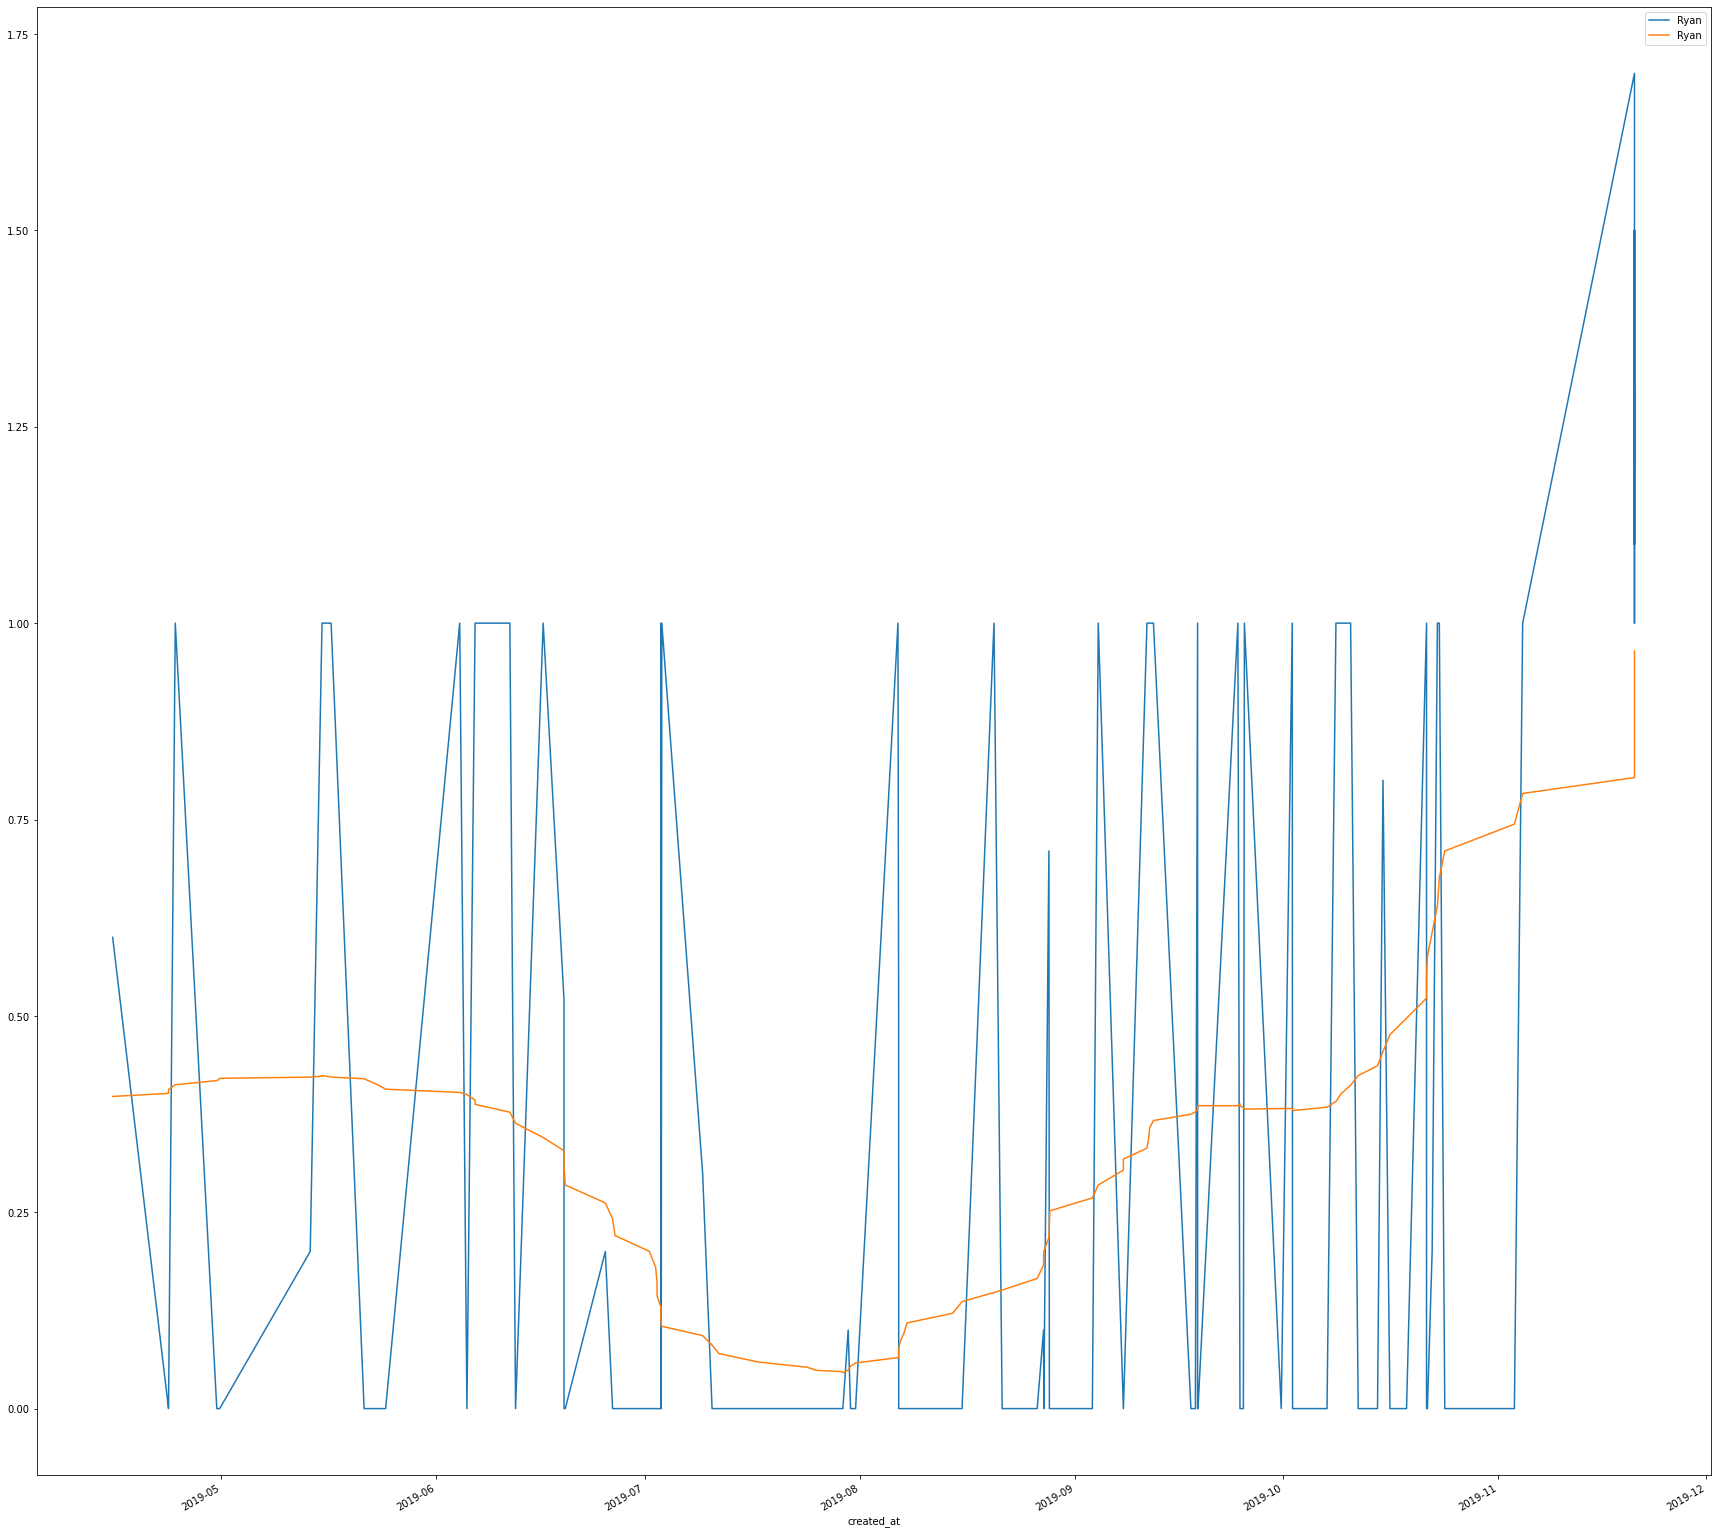

In [5]:
for x in candidates:
    print(x)
    
    ax = plt.gca()
    df_filtered[df_filtered.answer == x].plot(kind='line', x='created_at', y='pct', label=x, ax=ax, figsize=(30, 30))        
    df_filtered2[df_filtered2.answer == x].plot(kind='line', x='created_at', y='avg_pct', label=x, ax=ax)        
    plt.show()

In [6]:
# OLD PEAK RECOGNITION STUFF

# from scipy.signal import find_peaks

# results = dict()
# for x in candidates:
#     temp = get_temp(df_filtered, x)

#     peaks1, _ = find_peaks(temp.avg_pct)
#     peaks2, _ = find_peaks(-temp.avg_pct)
#     peaks = np.concatenate([temp.avg_pct[peaks1], temp.avg_pct[peaks2]])
#     peak_indices = np.concatenate([temp.index[peaks1], temp.index[peaks2]])
#     peaks = peaks[np.argsort(peak_indices)]
    
#     p = []
#     for i in range(len(peaks)):
#         if len(p) > 0:
#             if np.abs(peaks[i] - peaks[p[-1]]) / min(peaks[i], peaks[p[-1]]) * 100 > 10:
#                 p.append(i)
#         else:
#             p.append(i)

#     results[x] = np.sort(peak_indices)[p]
            
#     ax = plt.gca()
#     temp.plot(kind='line', x='created_at', y='avg_pct', label=x, ax=ax, figsize=(30, 30))
#     for y in np.sort(peak_indices)[p]:
#         plt.axvline(y, color='red')
#     for y in peak_indices:
#         plt.axvline(y, color='purple', linestyle='--')
        
#     plt.show()

In [7]:
# from datetime import datetime

nice_results = dict()

for c in candidates:
    nice_results[c] = df_filtered2[df_filtered2.answer == c][['created_at', 'avg_pct']].to_dict('records')
        
print(nice_results)

{'Biden': [{'created_at': Timestamp('2018-12-27 03:58:00'), 'avg_pct': 28.563390306030403}, {'created_at': Timestamp('2018-12-27 03:59:00'), 'avg_pct': 28.60853664184582}, {'created_at': Timestamp('2019-02-04 12:12:00'), 'avg_pct': 28.660741921692004}, {'created_at': Timestamp('2019-02-16 17:24:00'), 'avg_pct': 28.712607927715695}, {'created_at': Timestamp('2019-03-01 12:07:00'), 'avg_pct': 28.778493075736}, {'created_at': Timestamp('2019-03-11 12:07:00'), 'avg_pct': 28.86092687068693}, {'created_at': Timestamp('2019-03-19 16:06:00'), 'avg_pct': 28.914306441268998}, {'created_at': Timestamp('2019-03-19 16:36:00'), 'avg_pct': 28.990817827076707}, {'created_at': Timestamp('2019-03-24 09:51:00'), 'avg_pct': 29.161605725572446}, {'created_at': Timestamp('2019-03-28 08:31:00'), 'avg_pct': 29.412047529489683}, {'created_at': Timestamp('2019-04-15 08:01:00'), 'avg_pct': 29.7124451530152}, {'created_at': Timestamp('2019-04-23 09:12:00'), 'avg_pct': 30.026945153015202}, {'created_at': Timestamp